In [ ]:
import torch

class HingeLossSVM(torch.nn.Module):
    def __init__(self, input_dim, lambda_reg):
        super(HingeLossSVM, self).__init__()
        self.weights = torch.nn.Parameter(torch.randn(input_dim))
        self.lambda_reg = lambda_reg

    def forward(self, X, y):
        margin = 1 - y * (X @ self.weights)
        hinge_loss = torch.clamp(margin, min=0).mean()
        regularization = (self.lambda_reg / 2) * torch.norm(self.weights)**2
        return hinge_loss + regularization

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

def generate_dataset(n, d, mu, sigma, train_ratio=0.8, pos_ratio=0.5, batch_size=32):
    """
    Generates a dataset and splits it into train and test sets with balanced label proportions.

    Parameters:
    n (int): Total number of samples.
    d (int): Feature dimension.
    mu (torch.Tensor): Signal vector of shape (d,).
    sigma (float): Standard deviation of Gaussian noise.
    train_ratio (float): Proportion of the dataset used for training (default 0.8).
    pos_ratio (float): Proportion of positive labels (default 0.5, meaning balanced classes).
    batch_size (int): Batch size for DataLoader.

    Returns:
    train_loader (DataLoader): DataLoader for the training set.
    test_loader (DataLoader): DataLoader for the testing set.
    """

    n_pos = int(n * pos_ratio)
    n_neg = n - n_pos

    y_pos = torch.ones(n_pos)
    y_neg = -torch.ones(n_neg)
    y = torch.cat([y_pos, y_neg])

    noise = torch.randn(n, d) * sigma
    X = y.unsqueeze(1) * mu + noise

    indices = torch.randperm(n)
    X, y = X[indices], y[indices]

    n_train = int(n * train_ratio)
    n_test = n - n_train

    X_train, y_train = X[:n_train], y[:n_train]
    X_test, y_test = X[n_train:], y[n_train:]

    def balance_classes(X, y, size):
        """Randomly samples data while maintaining the same class ratio."""
        pos_indices = (y == 1).nonzero(as_tuple=True)[0]
        neg_indices = (y == -1).nonzero(as_tuple=True)[0]

        num_pos = size // 2
        num_neg = size - num_pos

        selected_pos = pos_indices[torch.randperm(len(pos_indices))[:num_pos]]
        selected_neg = neg_indices[torch.randperm(len(neg_indices))[:num_neg]]

        selected_indices = torch.cat([selected_pos, selected_neg])
        return X[selected_indices], y[selected_indices]

    X_train, y_train = balance_classes(X_train, y_train, n_train)
    X_test, y_test = balance_classes(X_test, y_test, n_test)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
import torch
from torch.optim import SGD
import matplotlib.pyplot as plt

def generate_condensed_dataset(training_data, training_labels, model, config):
    """
    Generate and optimize a condensed dataset for SVM using PyTorch and HingeLossSVM.

    Parameters:
    - training_data (torch.Tensor): Original training data (n, d).
    - training_labels (torch.Tensor): Original training labels (n,).
    - model (HingeLossSVM): Predefined SVM model.
    - config (dict): Configuration dictionary containing hyperparameters.

    Returns:
    - optimized_condensed_data (torch.Tensor): Optimized condensed dataset features (m, d).
    - optimized_condensed_labels (torch.Tensor): Optimized condensed dataset labels (m,).
    """

    device = config["common"]["device"]
    optimizer_type = config["svm"]["optimizer_type"]

    num_pos = config["condensed"]["num_pos_samples"]
    num_neg = config["condensed"]["num_neg_samples"]
    feature_dim = config["common"]["feature_dim"]
    init_std = config["condensed"]["init_std"]

    condensed_data = torch.randn(num_pos + num_neg, feature_dim, device=device) * init_std
    condensed_data = condensed_data.detach().requires_grad_(True)
    condensed_labels = torch.cat([torch.ones(num_pos, device=device), -torch.ones(num_neg, device=device)])

    optimizer_s = SGD([condensed_data], lr=config["condensed"]["eta_s"])

    loss_history = []
    grad_norms_condensed = []

    for t_out in range(config["condensed"]["T_out"]):
        model.weights.data = torch.randn_like(model.weights) * config["svm"]["weight_init_std"]
        optimizer_w = SGD([model.weights], lr=config["condensed"]["eta_w"])

        for t_in in range(config["condensed"]["T_in"]):
            loss_train = model(training_data, training_labels)
            grad_w_train = torch.autograd.grad(loss_train, model.weights, create_graph=True, retain_graph=True)[0]

            loss_test = model(condensed_data, condensed_labels)
            grad_w_test = torch.autograd.grad(loss_test, model.weights, create_graph=True, retain_graph=True)[0]

            for label in torch.unique(training_labels):
                label_mask = training_labels == label
                label_data = training_data[label_mask]
                label_labels = training_labels[label_mask]

                loss_train_label = model(label_data, label_labels)
                grad_w_train_label = torch.autograd.grad(loss_train_label, model.weights, create_graph=True, retain_graph=True)[0]

                label_condensed_mask = condensed_labels == label
                label_condensed_data = condensed_data[label_condensed_mask]
                label_condensed_labels = condensed_labels[label_condensed_mask]

                loss_test_label = model(label_condensed_data, label_condensed_labels)
                grad_w_test_label = torch.autograd.grad(loss_test_label, model.weights, create_graph=True, retain_graph=True)[0]

                distance = torch.norm(grad_w_train_label - grad_w_test_label, p=2)

                optimizer_s.zero_grad()
                distance.backward(retain_graph=True)

                grad_norm_condensed = condensed_data.grad.norm().item()
                grad_norms_condensed.append(grad_norm_condensed)

                if optimizer_type == "SGD":
                    optimizer_s.step()
                elif optimizer_type == "GD":
                    with torch.no_grad():
                        condensed_data -= config["condensed"]["eta_s"] * condensed_data.grad

            optimizer_w.zero_grad()
            loss_train.backward(retain_graph=True)
            optimizer_w.step()

    return condensed_data.detach(), condensed_labels.detach()


In [ ]:
import torch
import random
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def train_and_evaluate_svm(model, train_loader, test_loader, lr, epochs, device, optimizer_type="SGD", seed=None):
    """
    Train and evaluate an SVM model with a fixed random seed for reproducibility.

    Parameters:
    - model (HingeLossSVM): Predefined SVM model.
    - train_loader (DataLoader): DataLoader for training set.
    - test_loader (DataLoader): DataLoader for testing set.
    - lr (float): Learning rate for training.
    - epochs (int): Number of training epochs.
    - device (str): "cuda" or "cpu" for computation.
    - optimizer_type (str): "SGD" for stochastic updates, "GD" for full-batch updates.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - metrics (dict): A dictionary containing accuracy, precision, recall, and F1 score.
    - losses (list): List of loss values recorded per epoch.
    - accuracies (list): List of test accuracy values recorded per epoch.
    """

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    model.to(device)
    optimizer = torch.optim.SGD([model.weights], lr=lr) if optimizer_type == "SGD" else None
    losses = []
    accuracies = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        if optimizer_type == "SGD":
            for batch_data, batch_labels in train_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)

                optimizer.zero_grad()
                loss = model(batch_data, batch_labels)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

        elif optimizer_type == "GD":
            full_data, full_labels = next(iter(train_loader))
            full_data, full_labels = full_data.to(device), full_labels.to(device)

            loss = model(full_data, full_labels)
            total_loss = loss.item()

            model.weights.grad = torch.autograd.grad(loss, model.weights, create_graph=False)[0]
            with torch.no_grad():
                model.weights -= lr * model.weights.grad

        avg_loss = total_loss / len(train_loader) if optimizer_type == "SGD" else total_loss
        losses.append(avg_loss)

        model.eval()
        all_predictions, all_labels = [], []
        with torch.no_grad():
            for batch_data, batch_labels in test_loader:
                batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
                predictions = (batch_data @ model.weights > 0).float() * 2 - 1
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(batch_labels.cpu().numpy())

        test_accuracy = accuracy_score(all_labels, all_predictions)
        accuracies.append(test_accuracy)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{epochs} | Loss: {avg_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")

    metrics = {
        "accuracy": accuracies[-1],
        "precision": precision_recall_fscore_support(all_labels, all_predictions, average="binary", pos_label=1)[0],
        "recall": precision_recall_fscore_support(all_labels, all_predictions, average="binary", pos_label=1)[1],
        "f1_score": precision_recall_fscore_support(all_labels, all_predictions, average="binary", pos_label=1)[2],
    }

    return metrics, losses, accuracies

In [ ]:
import torch
import numpy as np
import random

# === Updated Config ===
config = {
    # Common parameters (shared across all components)
    "common": {
        "feature_dim": 500,  # Unified feature dimension
        "batch_size": 32,  # Shared batch size
        "device": "cuda" if torch.cuda.is_available() else "cpu",  # Shared compute device
        "seed": 42,  # Random seed for reproducibility
    },

    # SVM Model Parameters
    "svm": {
        "input_dim": lambda: config["common"]["feature_dim"],
        "lambda_reg": 1.0,
        "weight_init_std": 0.01,  # Standard deviation for model weight initialization
        "epochs": 70,  # Explicitly define epochs here
        "learning_rate": 0.05,  # Explicitly define learning rate
        "optimizer_type": "GD",  # "SGD" for stochastic updates, "GD" for full-batch updates
    },

    # Dataset Generation Parameters
    "dataset": {
        "n_samples": 1000,
        "feature_dim": lambda: config["common"]["feature_dim"],
        "mu": lambda: torch.zeros(config["common"]["feature_dim"]).fill_(0).index_fill_(0, torch.tensor([0]), 2.5),
        "sigma": 1.0,
        "train_ratio": 0.6,
        "pos_ratio": 0.5,
        "batch_size": lambda: config["common"]["batch_size"],
    },

    # Condensed Dataset Parameters
    "condensed": {
        "num_pos_samples": 20,
        "num_neg_samples": 20,
        "feature_dim": lambda: config["common"]["feature_dim"],
        "T_out": 50,
        "T_in": 10,
        "eta_s": 1.0,
        "eta_w": 0.05,
        "init_std": 0.01,  # Standard deviation for condensed dataset initialization
    }
}

# Resolve lambda references
for section in config.values():
    for key, value in section.items():
        if callable(value):
            section[key] = value()

def set_seed(seed):
    """ Set seed for reproducibility across NumPy, PyTorch, and Python. """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

set_seed(config["common"]["seed"])

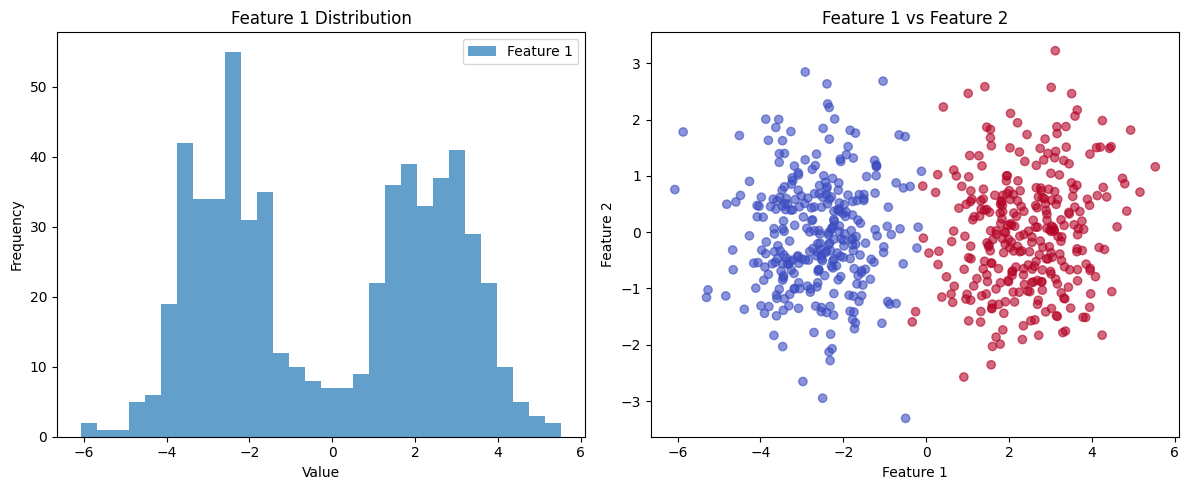

📊 Dataset Statistics:
- Train Data Mean: -0.0000, Std: 1.0042
- Test Data Mean: -0.0030, Std: 1.0042
- Training Samples: 597, Testing Samples: 397


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# === Generate Dataset ===
train_loader, test_loader = generate_dataset(
    n=config["dataset"]["n_samples"],
    d=config["dataset"]["feature_dim"],
    mu=config["dataset"]["mu"],
    sigma=config["dataset"]["sigma"],
    train_ratio=config["dataset"]["train_ratio"],
    pos_ratio=config["dataset"]["pos_ratio"],
    batch_size=config["dataset"]["batch_size"]
)

# Extract tensors from DataLoader
train_data, train_labels = train_loader.dataset.tensors
test_data, test_labels = test_loader.dataset.tensors

# Compute basic statistics
train_mean = train_data.mean(dim=0)
train_std = train_data.std(dim=0)
test_mean = test_data.mean(dim=0)
test_std = test_data.std(dim=0)

# Convert to numpy for visualization
train_labels_np = train_labels.cpu().numpy()
test_labels_np = test_labels.cpu().numpy()

# === Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))


# Histogram of first feature dimension
axes[0].hist(train_data[:, 0].cpu().numpy(), bins=30, alpha=0.7, label="Feature 1")
axes[0].set_title("Feature 1 Distribution")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Scatter plot of two dimensions (if feature_dim ≥ 2)
if config["dataset"]["feature_dim"] >= 2:
    scatter_x = train_data[:, 0].cpu().numpy()
    scatter_y = train_data[:, 1].cpu().numpy()
    axes[1].scatter(scatter_x, scatter_y, c=train_labels_np, cmap="coolwarm", alpha=0.6)
    axes[1].set_title("Feature 1 vs Feature 2")
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Print dataset statistics
print("📊 Dataset Statistics:")
print(f"- Train Data Mean: {train_mean.mean().item():.4f}, Std: {train_std.mean().item():.4f}")
print(f"- Test Data Mean: {test_mean.mean().item():.4f}, Std: {test_std.mean().item():.4f}")
print(f"- Training Samples: {len(train_labels_np)}, Testing Samples: {len(test_labels_np)}")


Epoch 10/70 | Loss: 112.6272 | Test Accuracy: 0.4584
Epoch 20/70 | Loss: 42.0874 | Test Accuracy: 0.5189
Epoch 30/70 | Loss: 14.8378 | Test Accuracy: 0.6045
Epoch 40/70 | Loss: 5.0726 | Test Accuracy: 0.7128
Epoch 50/70 | Loss: 1.8550 | Test Accuracy: 0.7985
Epoch 60/70 | Loss: 0.7073 | Test Accuracy: 0.8841
Epoch 70/70 | Loss: 0.3585 | Test Accuracy: 0.9320


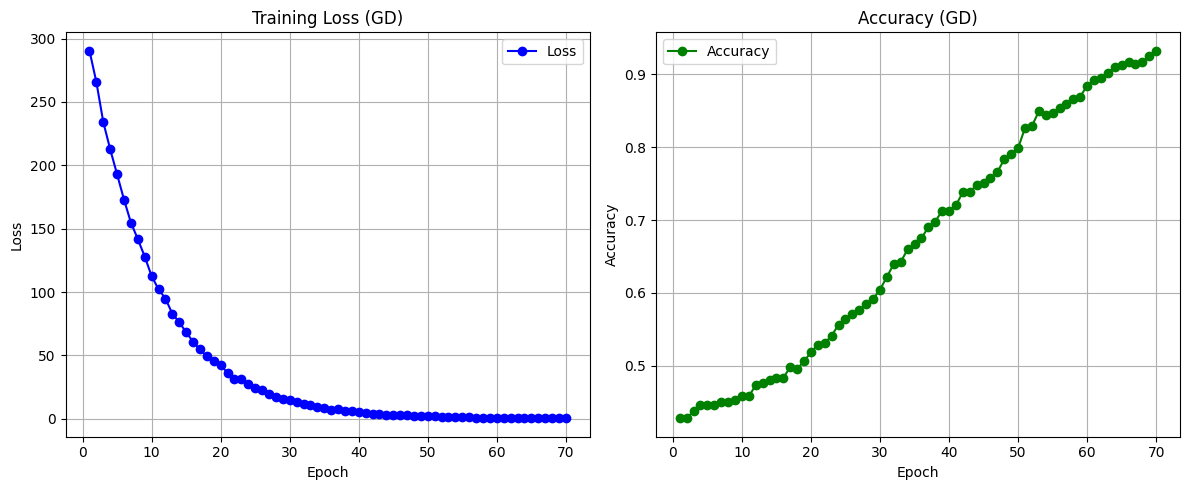

📊 SVM Training Summary on Original Dataset (GD):
- Accuracy: 0.9320
- Precision: 0.9250
- Recall: 0.9391
- F1_score: 0.9320


In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# === Train and Evaluate SVM on Original Dataset ===
model_original = HingeLossSVM(
    input_dim=config["svm"]["input_dim"],
    lambda_reg=config["svm"]["lambda_reg"]
).to(config["common"]["device"])

metrics_original, losses_original, accuracies_original = train_and_evaluate_svm(
    model=model_original,
    train_loader=train_loader,
    test_loader=test_loader,
    lr=config["svm"]["learning_rate"],
    epochs=config["svm"]["epochs"],
    device=config["common"]["device"],
    optimizer_type=config["svm"]["optimizer_type"],
    seed=config["common"]["seed"]
)

# Decide the number of plots based on feature dimension
num_plots = 3 if config["common"]["feature_dim"] == 2 else 2
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

# 1️⃣ Training Loss Curve
axes[0].plot(range(1, len(losses_original) + 1), losses_original, marker='o', color='b', label="Loss")
axes[0].set_title(f"Training Loss ({config['svm']['optimizer_type']})")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# 2️⃣ Accuracy Curve
axes[1].plot(range(1, len(accuracies_original) + 1), accuracies_original, marker='o', color='g', label="Accuracy")
axes[1].set_title(f"Accuracy ({config['svm']['optimizer_type']})")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid()
axes[1].legend()

# 3️⃣ Decision Boundary (Only if feature_dim == 2)
if config["common"]["feature_dim"] == 2:
    train_data, train_labels = train_loader.dataset.tensors
    train_data = train_data.cpu().numpy()
    train_labels = train_labels.cpu().numpy()

    # Create a grid
    x_min, x_max = train_data[:, 0].min() - 1, train_data[:, 0].max() + 1
    y_min, y_max = train_data[:, 1].min() - 1, train_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Generate predictions for grid points
    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(config["common"]["device"])
    predictions = (grid_points @ model.weights > 0).float().cpu().numpy()
    zz = predictions.reshape(xx.shape)

    # Plot decision boundary
    axes[2].contourf(xx, yy, zz, alpha=0.3, cmap='coolwarm')
    axes[2].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap="coolwarm", edgecolors="k")
    axes[2].set_title("SVM Decision Boundary")
    axes[2].set_xlabel("Feature 1")
    axes[2].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Print performance summary
print(f"📊 SVM Training Summary on Original Dataset ({config['svm']['optimizer_type']}):")
for key, value in metrics_original.items():
    print(f"- {key.capitalize()}: {value:.4f}")


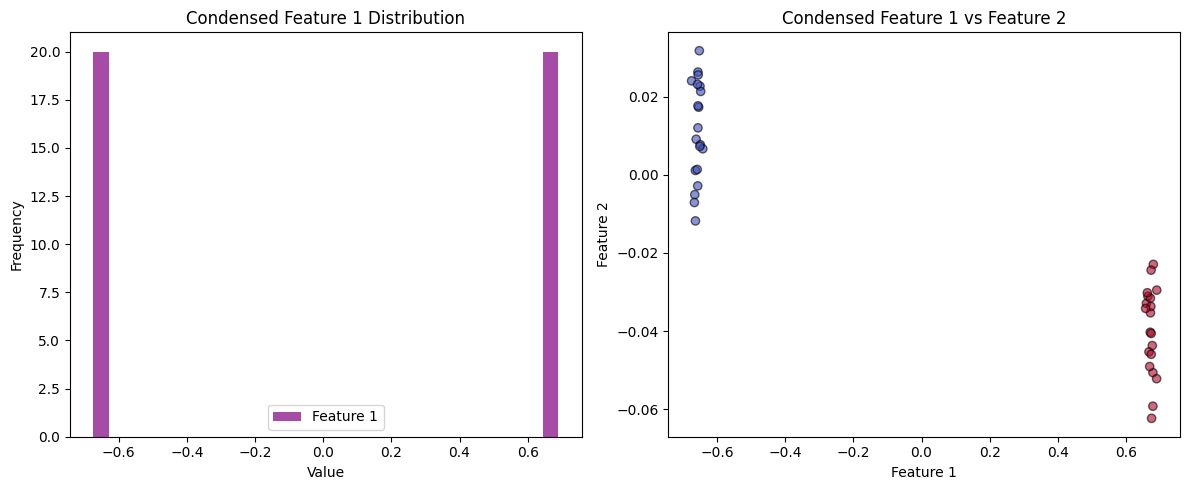

📊 Condensed Dataset Statistics:
- Condensed Data Mean: 0.0010, Std: 0.0431
- Condensed Samples: 40


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# === Generate Condensed Dataset ===
# Optimize condensed dataset directly within function
train_data, train_labels = train_loader.dataset.tensors

model_condensed = HingeLossSVM(
    input_dim=config["svm"]["input_dim"],
    lambda_reg=config["svm"]["lambda_reg"]
).to(config["common"]["device"])

optimized_condensed_data, optimized_condensed_labels = generate_condensed_dataset(
    training_data=train_data,
    training_labels=train_labels,
    model=model_condensed,
    config=config  # Pass the full config dictionary
)

# Convert to numpy for visualization
condensed_labels_np = optimized_condensed_labels.cpu().numpy()
condensed_data_np = optimized_condensed_data.cpu().numpy()

# === Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))



# Histogram of first feature dimension
axes[0].hist(condensed_data_np[:, 0], bins=30, alpha=0.7, label="Feature 1", color='purple')
axes[0].set_title("Condensed Feature 1 Distribution")
axes[0].set_xlabel("Value")
axes[0].set_ylabel("Frequency")
axes[0].legend()

# Scatter plot of two dimensions (if feature_dim ≥ 2)
if config["common"]["feature_dim"] >= 2:
    scatter_x = condensed_data_np[:, 0]
    scatter_y = condensed_data_np[:, 1]
    axes[1].scatter(scatter_x, scatter_y, c=condensed_labels_np, cmap="coolwarm", alpha=0.6, edgecolors="k")
    axes[1].set_title("Condensed Feature 1 vs Feature 2")
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Print dataset statistics
print("📊 Condensed Dataset Statistics:")
print(f"- Condensed Data Mean: {optimized_condensed_data.mean().item():.4f}, Std: {optimized_condensed_data.std().item():.4f}")
print(f"- Condensed Samples: {len(condensed_labels_np)}")


Epoch 10/70 | Loss: 35.8360 | Test Accuracy: 0.5718
Epoch 20/70 | Loss: 5.1843 | Test Accuracy: 0.6927
Epoch 30/70 | Loss: 1.2739 | Test Accuracy: 0.8816
Epoch 40/70 | Loss: 0.7788 | Test Accuracy: 0.9673
Epoch 50/70 | Loss: 0.7073 | Test Accuracy: 0.9773
Epoch 60/70 | Loss: 0.6996 | Test Accuracy: 0.9773
Epoch 70/70 | Loss: 0.7007 | Test Accuracy: 0.9798


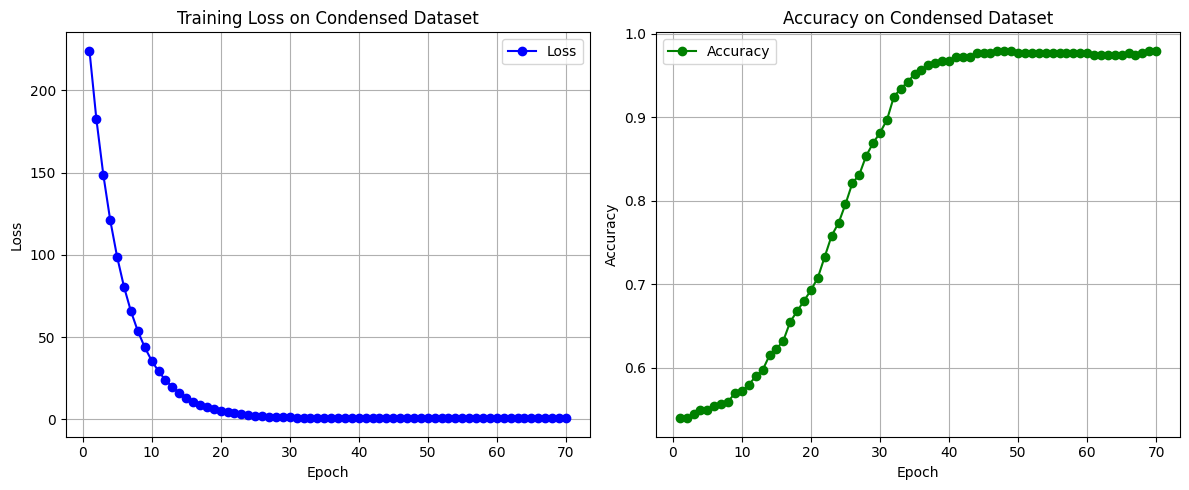

📊 SVM Training Summary on Condensed Dataset:
- Accuracy: 0.9798
- Precision: 0.9797
- Recall: 0.9797
- F1_score: 0.9797


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader

# === Train and Evaluate SVM on Condensed Dataset ===
# Create a DataLoader for the condensed dataset
condensed_loader = DataLoader(
    TensorDataset(optimized_condensed_data, optimized_condensed_labels),
    batch_size=config["common"]["batch_size"],
    shuffle=True
)

# Reinitialize the model for training
model = HingeLossSVM(
    input_dim=config["svm"]["input_dim"],
    lambda_reg=config["svm"]["lambda_reg"]
).to(config["common"]["device"])

# Train the model using the condensed dataset
metrics_condensed, losses_condensed, accuracies_condensed = train_and_evaluate_svm(
    model=model,
    train_loader=condensed_loader,  # Use condensed dataset for training
    test_loader=test_loader,  # Same test set for evaluation
    lr=config["svm"]["learning_rate"],
    epochs=config["svm"]["epochs"],
    device=config["common"]["device"],
    seed=config["common"]["seed"]
)

# === Visualization ===
num_plots = 3 if config["common"]["feature_dim"] == 2 else 2
fig, axes = plt.subplots(1, num_plots, figsize=(6 * num_plots, 5))

# 1️⃣ Training Loss Curve
axes[0].plot(range(1, len(losses_condensed) + 1), losses_condensed, marker='o', color='b', label="Loss")
axes[0].set_title("Training Loss on Condensed Dataset")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# 2️⃣ Accuracy Curve
axes[1].plot(range(1, len(accuracies_condensed) + 1), accuracies_condensed, marker='o', color='g', label="Accuracy")
axes[1].set_title("Accuracy on Condensed Dataset")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid()
axes[1].legend()

# 3️⃣ Decision Boundary (Only if feature_dim == 2)
if config["common"]["feature_dim"] == 2:
    condensed_data_np = optimized_condensed_data.cpu().numpy()
    condensed_labels_np = optimized_condensed_labels.cpu().numpy()

    x_min, x_max = condensed_data_np[:, 0].min() - 1, condensed_data_np[:, 0].max() + 1
    y_min, y_max = condensed_data_np[:, 1].min() - 1, condensed_data_np[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    grid_points = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32).to(config["common"]["device"])
    predictions = (grid_points @ model.weights > 0).float().cpu().numpy()
    zz = predictions.reshape(xx.shape)

    axes[2].contourf(xx, yy, zz, alpha=0.3, cmap='coolwarm')
    axes[2].scatter(condensed_data_np[:, 0], condensed_data_np[:, 1], c=condensed_labels_np, cmap="coolwarm", edgecolors="k")
    axes[2].set_title("Decision Boundary on Condensed Dataset")
    axes[2].set_xlabel("Feature 1")
    axes[2].set_ylabel("Feature 2")

plt.tight_layout()
plt.show()

# Print evaluation results
print("📊 SVM Training Summary on Condensed Dataset:")
for key, value in metrics_condensed.items():
    print(f"- {key.capitalize()}: {value:.4f}")


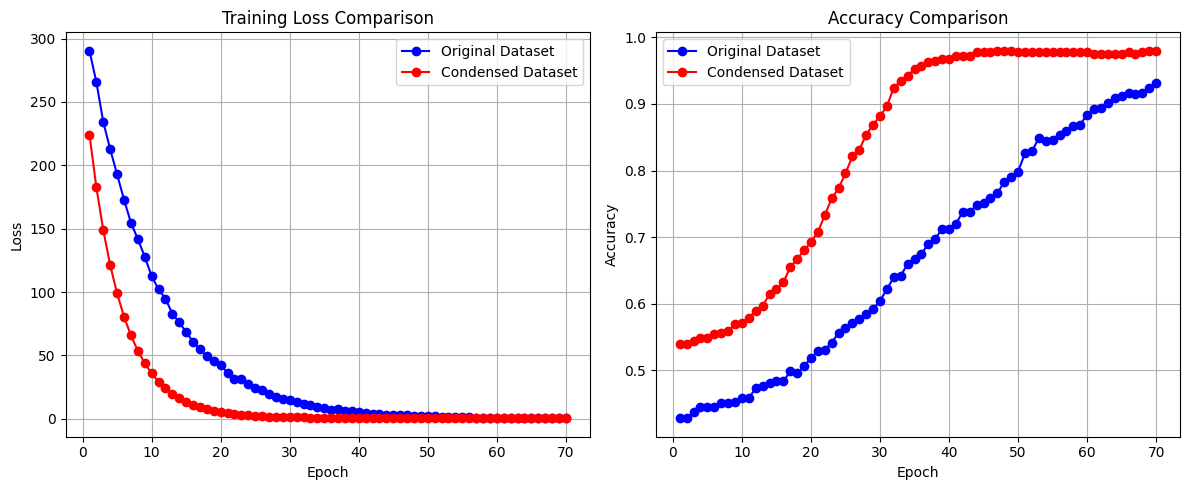


📊 Final Evaluation Metrics Comparison:
🔹 Original Dataset: Accuracy = 0.9320, F1 Score = 0.9320
🔸 Condensed Dataset: Accuracy = 0.9798, F1 Score = 0.9797


In [ ]:
import matplotlib.pyplot as plt
import torch

# === Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1️⃣ Training Loss Curve
axes[0].plot(range(1, len(losses_original) + 1), losses_original, marker='o', color='b', label="Original Dataset")
axes[0].plot(range(1, len(losses_condensed) + 1), losses_condensed, marker='o', color='r', label="Condensed Dataset")
axes[0].set_title("Training Loss Comparison")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid()
axes[0].legend()

# 2️⃣ Accuracy Curve
axes[1].plot(range(1, len(accuracies_original) + 1), accuracies_original, marker='o', color='b', label="Original Dataset")
axes[1].plot(range(1, len(accuracies_condensed) + 1), accuracies_condensed, marker='o', color='r', label="Condensed Dataset")
axes[1].set_title("Accuracy Comparison")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

# Print final evaluation metrics
print("\n📊 Final Evaluation Metrics Comparison:")
print(f"🔹 Original Dataset: Accuracy = {metrics_original['accuracy']:.4f}, F1 Score = {metrics_original['f1_score']:.4f}")
print(f"🔸 Condensed Dataset: Accuracy = {metrics_condensed['accuracy']:.4f}, F1 Score = {metrics_condensed['f1_score']:.4f}")


In [ ]:
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt

def heatmap_feature_mu(feature_dims, mu_values, config):
    """
    Generate heatmaps and grid plots showing the effect of feature dimension and mu[0]
    on training loss and test accuracy for both the original dataset and condensed dataset.
    """

    results = {"original": {}, "condensed": {}}
    loss_original = np.zeros((len(mu_values), len(feature_dims)))
    accuracy_original = np.zeros((len(mu_values), len(feature_dims)))
    loss_condensed = np.zeros((len(mu_values), len(feature_dims)))
    accuracy_condensed = np.zeros((len(mu_values), len(feature_dims)))

    all_losses = {}
    all_accuracies = {}

    for i, mu_0 in enumerate(mu_values):
        for j, feature_dim in enumerate(feature_dims):
            print(f"🔄 Running experiment for feature_dim={feature_dim}, mu[0]={mu_0}...")

            local_config = copy.deepcopy(config)

            local_config["common"]["feature_dim"] = feature_dim
            local_config["dataset"]["mu"] = torch.zeros(feature_dim).fill_(0).index_fill_(0, torch.tensor([0]), mu_0)

            train_loader, test_loader = generate_dataset(
                n=local_config["dataset"]["n_samples"],
                d=feature_dim,
                mu=local_config["dataset"]["mu"],
                sigma=local_config["dataset"]["sigma"],
                train_ratio=local_config["dataset"]["train_ratio"],
                pos_ratio=local_config["dataset"]["pos_ratio"],
                batch_size=local_config["dataset"]["batch_size"]
            )

            model = HingeLossSVM(feature_dim, local_config["svm"]["lambda_reg"]).to(local_config["common"]["device"])
            metrics, losses, accuracies = train_and_evaluate_svm(
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                lr=local_config["svm"]["learning_rate"],
                epochs=local_config["svm"]["epochs"],
                device=local_config["common"]["device"],
                optimizer_type=local_config["svm"]["optimizer_type"],
                seed=config["common"]["seed"]
            )

            loss_original[i, j] = losses[-1]
            accuracy_original[i, j] = metrics["accuracy"]
            results["original"][(feature_dim, mu_0)] = {"loss": losses[-1], "accuracy": metrics["accuracy"]}

            all_losses[(feature_dim, mu_0, "original")] = losses
            all_accuracies[(feature_dim, mu_0, "original")] = accuracies

            train_data, train_labels = train_loader.dataset.tensors
            optimized_condensed_data, optimized_condensed_labels = generate_condensed_dataset(
                training_data=train_data,
                training_labels=train_labels,
                model=model,
                config=local_config
            )

            condensed_loader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(optimized_condensed_data, optimized_condensed_labels),
                batch_size=local_config["common"]["batch_size"],
                shuffle=True
            )

            model_condensed = HingeLossSVM(feature_dim, local_config["svm"]["lambda_reg"]).to(local_config["common"]["device"])
            metrics, losses, accuracies = train_and_evaluate_svm(
                model=model_condensed,
                train_loader=condensed_loader,
                test_loader=test_loader,
                lr=local_config["svm"]["learning_rate"],
                epochs=local_config["svm"]["epochs"],
                device=local_config["common"]["device"],
                optimizer_type=local_config["svm"]["optimizer_type"],
                seed=config["common"]["seed"]
            )

            loss_condensed[i, j] = losses[-1]
            accuracy_condensed[i, j] = metrics["accuracy"]
            results["condensed"][(feature_dim, mu_0)] = {"loss": losses[-1], "accuracy": metrics["accuracy"]}

            all_losses[(feature_dim, mu_0, "condensed")] = losses
            all_accuracies[(feature_dim, mu_0, "condensed")] = accuracies

            print(f"✅ Done: Feature Dim={feature_dim}, Mu[0]={mu_0} -> Loss(Orig): {loss_original[i, j]:.4f}, Acc(Orig): {accuracy_original[i, j]:.4f}, Loss(Cond): {loss_condensed[i, j]:.4f}, Acc(Cond): {accuracy_condensed[i, j]:.4f}")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    vmin_loss = min(loss_original.min(), loss_condensed.min())
    vmax_loss = max(loss_original.max(), loss_condensed.max())
    vmin_acc = min(accuracy_original.min(), accuracy_condensed.min())
    vmax_acc = max(accuracy_original.max(), accuracy_condensed.max())

    heatmaps = [
        (axes[0, 0], loss_original, "Final Training Loss (Original Dataset)", "viridis", vmin_loss, vmax_loss),
        (axes[0, 1], loss_condensed, "Final Training Loss (Condensed Dataset)", "viridis", vmin_loss, vmax_loss),
        (axes[1, 0], accuracy_original, "Final Test Accuracy (Original Dataset)", "coolwarm", vmin_acc, vmax_acc),
        (axes[1, 1], accuracy_condensed, "Final Test Accuracy (Condensed Dataset)", "coolwarm", vmin_acc, vmax_acc),
    ]

    for ax, data, title, cmap, vmin, vmax in heatmaps:
        im = ax.imshow(data, aspect="auto", cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel("Feature Dimension")
        ax.set_ylabel("Mu[0] Value")
        ax.set_xticks(np.arange(len(feature_dims)))
        ax.set_xticklabels(feature_dims)
        ax.set_yticks(np.arange(len(mu_values)))
        ax.set_yticklabels(mu_values)
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(mu_values), len(feature_dims), figsize=(5 * len(feature_dims), 4 * len(mu_values)))

    for i, mu_0 in enumerate(mu_values):
        for j, feature_dim in enumerate(feature_dims):
            ax = axes[i, j]
            loss_orig = all_losses.get((feature_dim, mu_0, "original"), [])
            loss_cond = all_losses.get((feature_dim, mu_0, "condensed"), [])

            if loss_orig and loss_cond:
                ax.plot(range(len(loss_orig)), loss_orig, label="Original", color='blue')
                ax.plot(range(len(loss_cond)), loss_cond, label="Condensed", color='red')

            ax.set_title(f"Loss - Dim={feature_dim}, Mu[0]={mu_0}")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Training Loss")
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(mu_values), len(feature_dims), figsize=(5 * len(feature_dims), 4 * len(mu_values)))

    for i, mu_0 in enumerate(mu_values):
        for j, feature_dim in enumerate(feature_dims):
            ax = axes[i, j]
            acc_orig = all_accuracies.get((feature_dim, mu_0, "original"), [])
            acc_cond = all_accuracies.get((feature_dim, mu_0, "condensed"), [])

            if acc_orig and acc_cond:
                ax.plot(range(len(acc_orig)), acc_orig, label="Original", color='green')
                ax.plot(range(len(acc_cond)), acc_cond, label="Condensed", color='orange')

            ax.set_title(f"Accuracy - Dim={feature_dim}, Mu[0]={mu_0}")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Test Accuracy")
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    return results

In [ ]:
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt

def heatmap_Tin_Tout(Tin_values, Tout_values, config):
    """
    Generate heatmaps and grid plots showing the effect of T_in and T_out on training loss and test accuracy.
    """

    results = {"original": {}, "condensed": {}}
    loss_original = np.zeros((len(Tout_values), len(Tin_values)))
    accuracy_original = np.zeros((len(Tout_values), len(Tin_values)))
    loss_condensed = np.zeros((len(Tout_values), len(Tin_values)))
    accuracy_condensed = np.zeros((len(Tout_values), len(Tin_values)))

    all_losses = {}
    all_accuracies = {}
    print("🔄 Generating dataset and training SVM on the original dataset (Only once)...")

    train_loader, test_loader = generate_dataset(
        n=config["dataset"]["n_samples"],
        d=config["common"]["feature_dim"],
        mu=config["dataset"]["mu"],
        sigma=config["dataset"]["sigma"],
        train_ratio=config["dataset"]["train_ratio"],
        pos_ratio=config["dataset"]["pos_ratio"],
        batch_size=config["dataset"]["batch_size"]
    )

    model_original = HingeLossSVM(config["common"]["feature_dim"], config["svm"]["lambda_reg"]).to(config["common"]["device"])
    metrics_orig, losses_orig, accuracies_orig = train_and_evaluate_svm(
        model=model_original,
        train_loader=train_loader,
        test_loader=test_loader,
        lr=config["svm"]["learning_rate"],
        epochs=config["svm"]["epochs"],
        device=config["common"]["device"],
        optimizer_type=config["svm"]["optimizer_type"],
        seed=config["common"]["seed"]
    )

    loss_original[:, :] = losses_orig[-1]
    accuracy_original[:, :] = metrics_orig["accuracy"]

    for i, Tout in enumerate(Tout_values):
        for j, Tin in enumerate(Tin_values):
            print(f"🔄 Running experiment for T_out={Tout}, T_in={Tin}...")

            local_config = copy.deepcopy(config)
            local_config["condensed"]["T_out"] = Tout
            local_config["condensed"]["T_in"] = Tin

            train_data, train_labels = train_loader.dataset.tensors
            model = HingeLossSVM(local_config["common"]["feature_dim"], local_config["svm"]["lambda_reg"]).to(local_config["common"]["device"])

            optimized_condensed_data, optimized_condensed_labels = generate_condensed_dataset(
                training_data=train_data,
                training_labels=train_labels,
                model=model,
                config=local_config
            )

            condensed_loader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(optimized_condensed_data, optimized_condensed_labels),
                batch_size=local_config["common"]["batch_size"],
                shuffle=True
            )

            model_condensed = HingeLossSVM(local_config["common"]["feature_dim"], local_config["svm"]["lambda_reg"]).to(local_config["common"]["device"])
            metrics, losses, accuracies = train_and_evaluate_svm(
                model=model_condensed,
                train_loader=condensed_loader,
                test_loader=test_loader,
                lr=local_config["svm"]["learning_rate"],
                epochs=local_config["svm"]["epochs"],
                device=local_config["common"]["device"],
                optimizer_type=local_config["svm"]["optimizer_type"],
                seed=config["common"]["seed"]
            )

            loss_condensed[i, j] = losses[-1]
            accuracy_condensed[i, j] = metrics["accuracy"]
            results["condensed"][(Tout, Tin)] = {"loss": losses[-1], "accuracy": metrics["accuracy"]}

            all_losses[(Tout, Tin)] = losses
            all_accuracies[(Tout, Tin)] = accuracies

            print(f"✅ Done: T_out={Tout}, T_in={Tin} -> Loss(Cond): {loss_condensed[i, j]:.4f}, Acc(Cond): {accuracy_condensed[i, j]:.4f}")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    vmin_loss = min(loss_original.min(), loss_condensed.min())
    vmax_loss = max(loss_original.max(), loss_condensed.max())
    vmin_acc = min(accuracy_original.min(), accuracy_condensed.min())
    vmax_acc = max(accuracy_original.max(), accuracy_condensed.max())

    heatmaps = [
        (axes[0, 0], loss_original, "Final Training Loss (Original Dataset)", "viridis", vmin_loss, vmax_loss),
        (axes[0, 1], loss_condensed, "Final Training Loss (Condensed Dataset)", "viridis", vmin_loss, vmax_loss),
        (axes[1, 0], accuracy_original, "Final Test Accuracy (Original Dataset)", "coolwarm", vmin_acc, vmax_acc),
        (axes[1, 1], accuracy_condensed, "Final Test Accuracy (Condensed Dataset)", "coolwarm", vmin_acc, vmax_acc),
    ]

    for ax, data, title, cmap, vmin, vmax in heatmaps:
        im = ax.imshow(data, aspect="auto", cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel("T_in")
        ax.set_ylabel("T_out")
        ax.set_xticks(np.arange(len(Tin_values)))
        ax.set_xticklabels(Tin_values)
        ax.set_yticks(np.arange(len(Tout_values)))
        ax.set_yticklabels(Tout_values)
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(Tout_values), len(Tin_values), figsize=(5 * len(Tin_values), 4 * len(Tout_values)))

    for i, Tout in enumerate(Tout_values):
        for j, Tin in enumerate(Tin_values):
            ax = axes[i, j]
            loss_cond = all_losses.get((Tout, Tin), [])

            if loss_cond:
                ax.plot(range(len(losses_orig)), losses_orig, label="Original", color='blue')
                ax.plot(range(len(loss_cond)), loss_cond, label="Condensed", color='red')
                ax.legend()

            ax.set_title(f"Loss - T_out={Tout}, T_in={Tin}")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Training Loss")
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(Tout_values), len(Tin_values), figsize=(5 * len(Tin_values), 4 * len(Tout_values)))

    for i, Tout in enumerate(Tout_values):
        for j, Tin in enumerate(Tin_values):
            ax = axes[i, j]
            acc_cond = all_accuracies.get((Tout, Tin), [])

            if acc_cond:
                ax.plot(range(len(accuracies_orig)), accuracies_orig, label="Original", color='green')
                ax.plot(range(len(acc_cond)), acc_cond, label="Condensed", color='orange')
                ax.legend()

            ax.set_title(f"Accuracy - T_out={Tout}, T_in={Tin}")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Test Accuracy")
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    return results


In [ ]:
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt

def heatmap_samples_posratio(n_samples_list, pos_ratio_list, config):
    """
    Generate heatmaps and grid plots showing the effect of dataset size and positive class ratio
    on training loss and test accuracy for both the original dataset and condensed dataset.
    """

    results = {"original": {}, "condensed": {}}
    loss_original = np.zeros((len(pos_ratio_list), len(n_samples_list)))
    accuracy_original = np.zeros((len(pos_ratio_list), len(n_samples_list)))
    loss_condensed = np.zeros((len(pos_ratio_list), len(n_samples_list)))
    accuracy_condensed = np.zeros((len(pos_ratio_list), len(n_samples_list)))

    all_losses = {}
    all_accuracies = {}

    for i, pos_ratio in enumerate(pos_ratio_list):
        for j, n_samples in enumerate(n_samples_list):
            print(f"🔄 Running experiment for n_samples={n_samples}, pos_ratio={pos_ratio}...")

            local_config = copy.deepcopy(config)

            local_config["dataset"]["n_samples"] = n_samples
            local_config["dataset"]["pos_ratio"] = pos_ratio

            train_loader, test_loader = generate_dataset(
                n=local_config["dataset"]["n_samples"],
                d=local_config["common"]["feature_dim"],
                mu=local_config["dataset"]["mu"],
                sigma=local_config["dataset"]["sigma"],
                train_ratio=local_config["dataset"]["train_ratio"],
                pos_ratio=local_config["dataset"]["pos_ratio"],
                batch_size=local_config["dataset"]["batch_size"]
            )

            model = HingeLossSVM(local_config["common"]["feature_dim"], local_config["svm"]["lambda_reg"]).to(local_config["common"]["device"])
            metrics, losses, accuracies = train_and_evaluate_svm(
                model=model,
                train_loader=train_loader,
                test_loader=test_loader,
                lr=local_config["svm"]["learning_rate"],
                epochs=local_config["svm"]["epochs"],
                device=local_config["common"]["device"],
                optimizer_type=local_config["svm"]["optimizer_type"],
                seed=config["common"]["seed"]
            )

            loss_original[i, j] = losses[-1]
            accuracy_original[i, j] = metrics["accuracy"]
            results["original"][(n_samples, pos_ratio)] = {"loss": losses[-1], "accuracy": metrics["accuracy"]}

            all_losses[(n_samples, pos_ratio, "original")] = losses
            all_accuracies[(n_samples, pos_ratio, "original")] = accuracies

            train_data, train_labels = train_loader.dataset.tensors
            optimized_condensed_data, optimized_condensed_labels = generate_condensed_dataset(
                training_data=train_data,
                training_labels=train_labels,
                model=model,
                config=local_config
            )

            condensed_loader = torch.utils.data.DataLoader(
                torch.utils.data.TensorDataset(optimized_condensed_data, optimized_condensed_labels),
                batch_size=local_config["common"]["batch_size"],
                shuffle=True
            )

            model_condensed = HingeLossSVM(local_config["common"]["feature_dim"], local_config["svm"]["lambda_reg"]).to(local_config["common"]["device"])
            metrics, losses, accuracies = train_and_evaluate_svm(
                model=model_condensed,
                train_loader=condensed_loader,
                test_loader=test_loader,
                lr=local_config["svm"]["learning_rate"],
                epochs=local_config["svm"]["epochs"],
                device=local_config["common"]["device"],
                optimizer_type=local_config["svm"]["optimizer_type"],
                seed=config["common"]["seed"]
            )

            loss_condensed[i, j] = losses[-1]
            accuracy_condensed[i, j] = metrics["accuracy"]
            results["condensed"][(n_samples, pos_ratio)] = {"loss": losses[-1], "accuracy": metrics["accuracy"]}

            all_losses[(n_samples, pos_ratio, "condensed")] = losses
            all_accuracies[(n_samples, pos_ratio, "condensed")] = accuracies

            print(f"✅ Done: n_samples={n_samples}, pos_ratio={pos_ratio} -> Loss(Orig): {loss_original[i, j]:.4f}, Acc(Orig): {accuracy_original[i, j]:.4f}, Loss(Cond): {loss_condensed[i, j]:.4f}, Acc(Cond): {accuracy_condensed[i, j]:.4f}")

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    vmin_loss = min(loss_original.min(), loss_condensed.min())
    vmax_loss = max(loss_original.max(), loss_condensed.max())
    vmin_acc = min(accuracy_original.min(), accuracy_condensed.min())
    vmax_acc = max(accuracy_original.max(), accuracy_condensed.max())

    heatmaps = [
        (axes[0, 0], loss_original, "Final Training Loss (Original Dataset)", "viridis", vmin_loss, vmax_loss),
        (axes[0, 1], loss_condensed, "Final Training Loss (Condensed Dataset)", "viridis", vmin_loss, vmax_loss),
        (axes[1, 0], accuracy_original, "Final Test Accuracy (Original Dataset)", "coolwarm", vmin_acc, vmax_acc),
        (axes[1, 1], accuracy_condensed, "Final Test Accuracy (Condensed Dataset)", "coolwarm", vmin_acc, vmax_acc),
    ]

    for ax, data, title, cmap, vmin, vmax in heatmaps:
        im = ax.imshow(data, aspect="auto", cmap=cmap, origin="lower", vmin=vmin, vmax=vmax)
        ax.set_title(title)
        ax.set_xlabel("Number of Training Samples")
        ax.set_ylabel("Positive Class Ratio")
        ax.set_xticks(np.arange(len(n_samples_list)))
        ax.set_xticklabels(n_samples_list)
        ax.set_yticks(np.arange(len(pos_ratio_list)))
        ax.set_yticklabels(pos_ratio_list)
        fig.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(pos_ratio_list), len(n_samples_list), figsize=(5 * len(n_samples_list), 4 * len(pos_ratio_list)))

    for i, pos_ratio in enumerate(pos_ratio_list):
        for j, n_samples in enumerate(n_samples_list):
            ax = axes[i, j]
            loss_orig = all_losses.get((n_samples, pos_ratio, "original"), [])
            loss_cond = all_losses.get((n_samples, pos_ratio, "condensed"), [])

            if loss_orig and loss_cond:
                ax.plot(range(len(loss_orig)), loss_orig, label="Original", color='blue')
                ax.plot(range(len(loss_cond)), loss_cond, label="Condensed", color='red')

            ax.set_title(f"Loss - Train={n_samples}, Pos Ratio={pos_ratio}")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Training Loss")
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    fig, axes = plt.subplots(len(pos_ratio_list), len(n_samples_list), figsize=(5 * len(n_samples_list), 4 * len(pos_ratio_list)))

    for i, pos_ratio in enumerate(pos_ratio_list):
        for j, n_samples in enumerate(n_samples_list):
            ax = axes[i, j]
            acc_orig = all_accuracies.get((n_samples, pos_ratio, "original"), [])
            acc_cond = all_accuracies.get((n_samples, pos_ratio, "condensed"), [])

            if acc_orig and acc_cond:
                ax.plot(range(len(acc_orig)), acc_orig, label="Original", color='green')
                ax.plot(range(len(acc_cond)), acc_cond, label="Condensed", color='orange')

            ax.set_title(f"Accuracy - Train={n_samples}, Pos Ratio={pos_ratio}")
            ax.set_xlabel("Epochs")
            ax.set_ylabel("Test Accuracy")
            ax.legend()
            ax.grid(True)

    plt.tight_layout()
    plt.show()

    return results

🔄 Running experiment for feature_dim=10, mu[0]=0.1...
Epoch 10/70 | Loss: 2.8566 | Test Accuracy: 0.4937
Epoch 20/70 | Loss: 1.4441 | Test Accuracy: 0.4886
Epoch 30/70 | Loss: 1.0355 | Test Accuracy: 0.4709
Epoch 40/70 | Loss: 1.0085 | Test Accuracy: 0.4861
Epoch 50/70 | Loss: 0.9565 | Test Accuracy: 0.4759
Epoch 60/70 | Loss: 0.9931 | Test Accuracy: 0.4861
Epoch 70/70 | Loss: 0.9518 | Test Accuracy: 0.4911
Epoch 10/70 | Loss: 4.7679 | Test Accuracy: 0.5519
Epoch 20/70 | Loss: 2.3373 | Test Accuracy: 0.5519
Epoch 30/70 | Loss: 1.4707 | Test Accuracy: 0.5392
Epoch 40/70 | Loss: 1.1611 | Test Accuracy: 0.5342
Epoch 50/70 | Loss: 1.0476 | Test Accuracy: 0.5190
Epoch 60/70 | Loss: 1.0077 | Test Accuracy: 0.5038
Epoch 70/70 | Loss: 0.9936 | Test Accuracy: 0.4835
✅ Done: Feature Dim=10, Mu[0]=0.1 -> Loss(Orig): 0.9518, Acc(Orig): 0.4911, Loss(Cond): 0.9936, Acc(Cond): 0.4835
🔄 Running experiment for feature_dim=50, mu[0]=0.1...
Epoch 10/70 | Loss: 7.3573 | Test Accuracy: 0.4783
Epoch 20/70 |

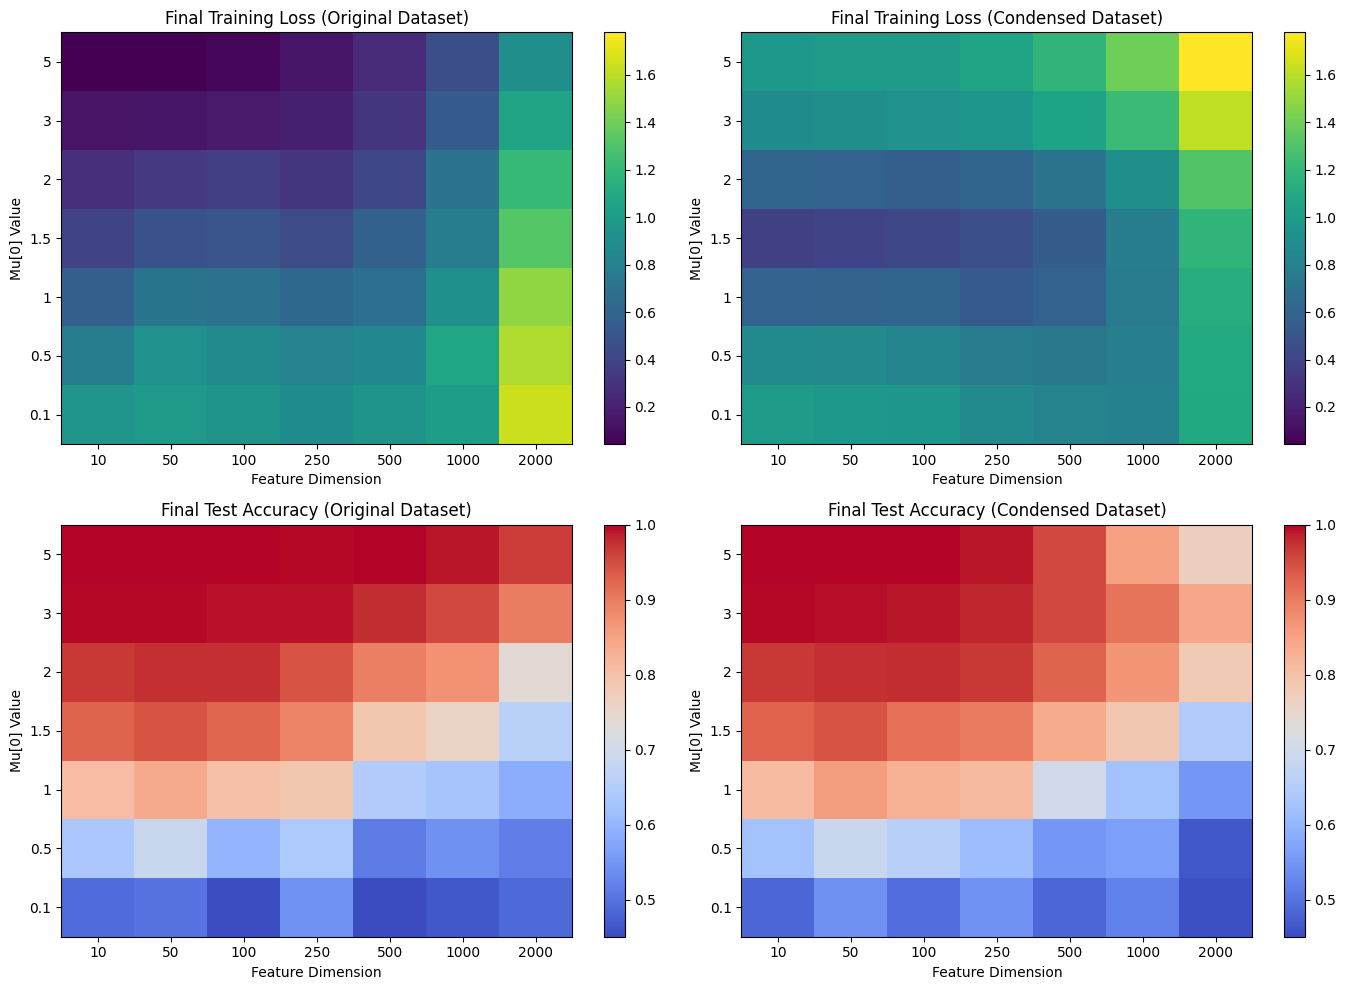

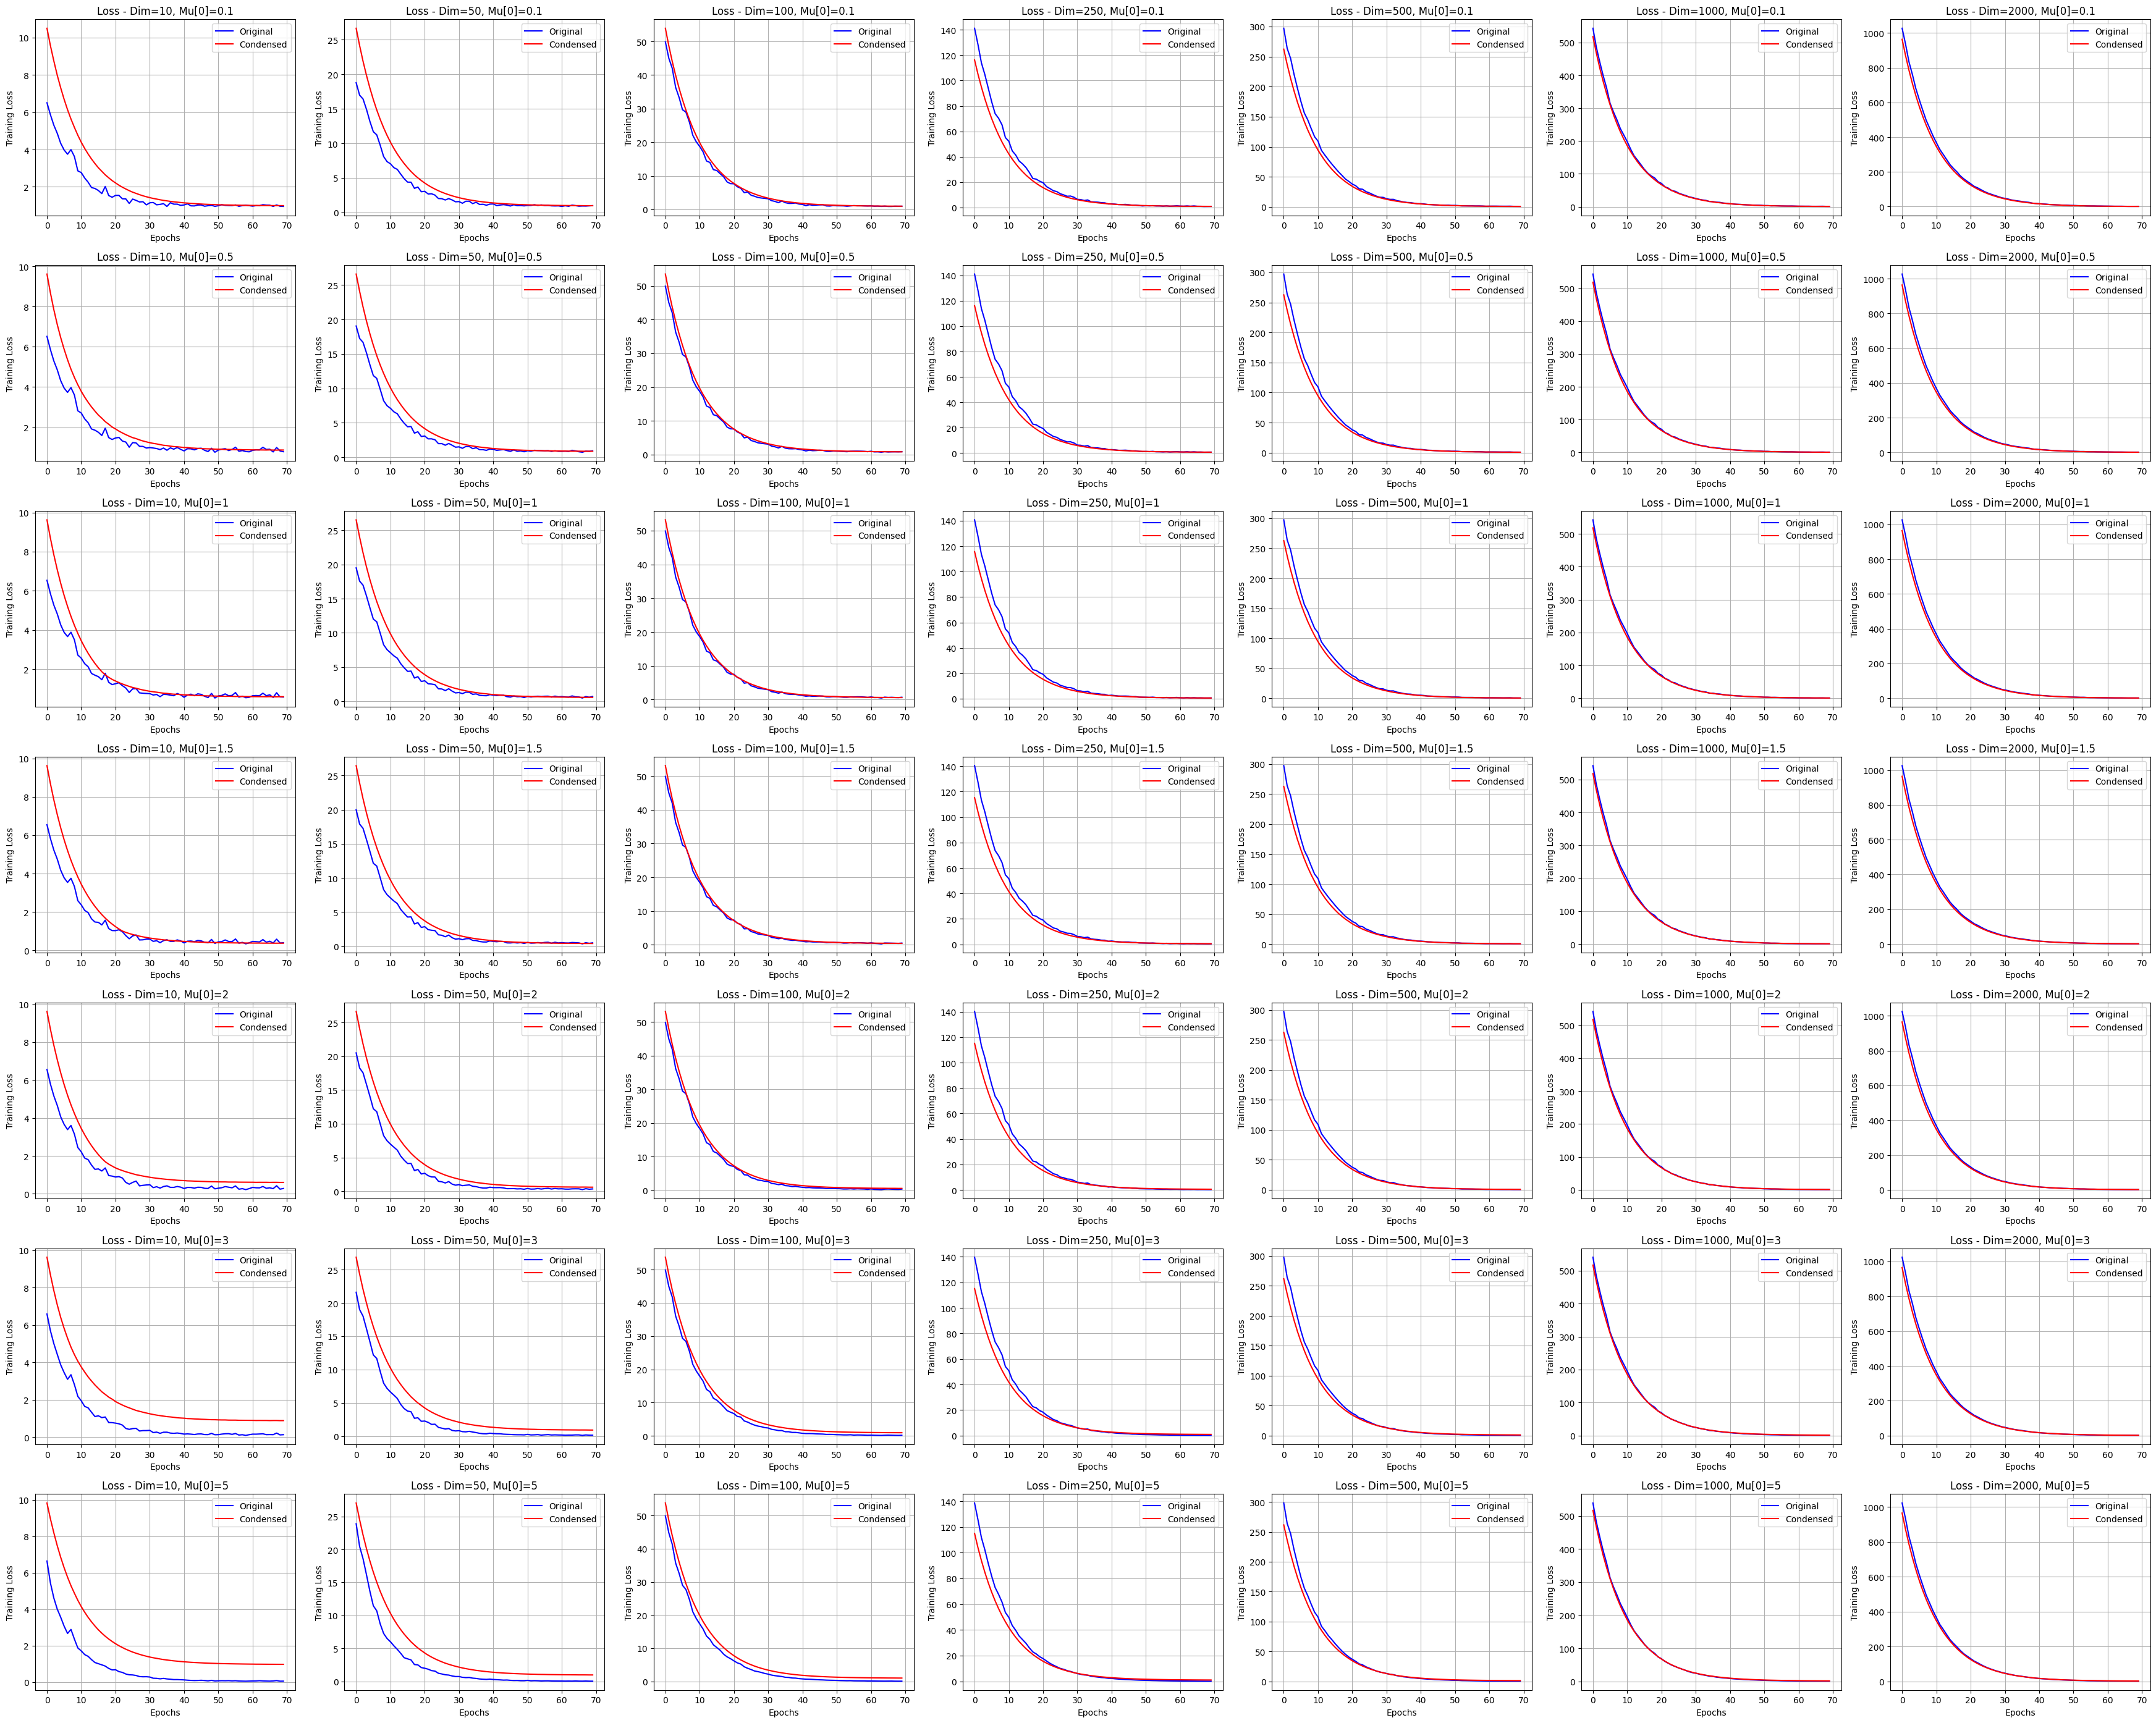

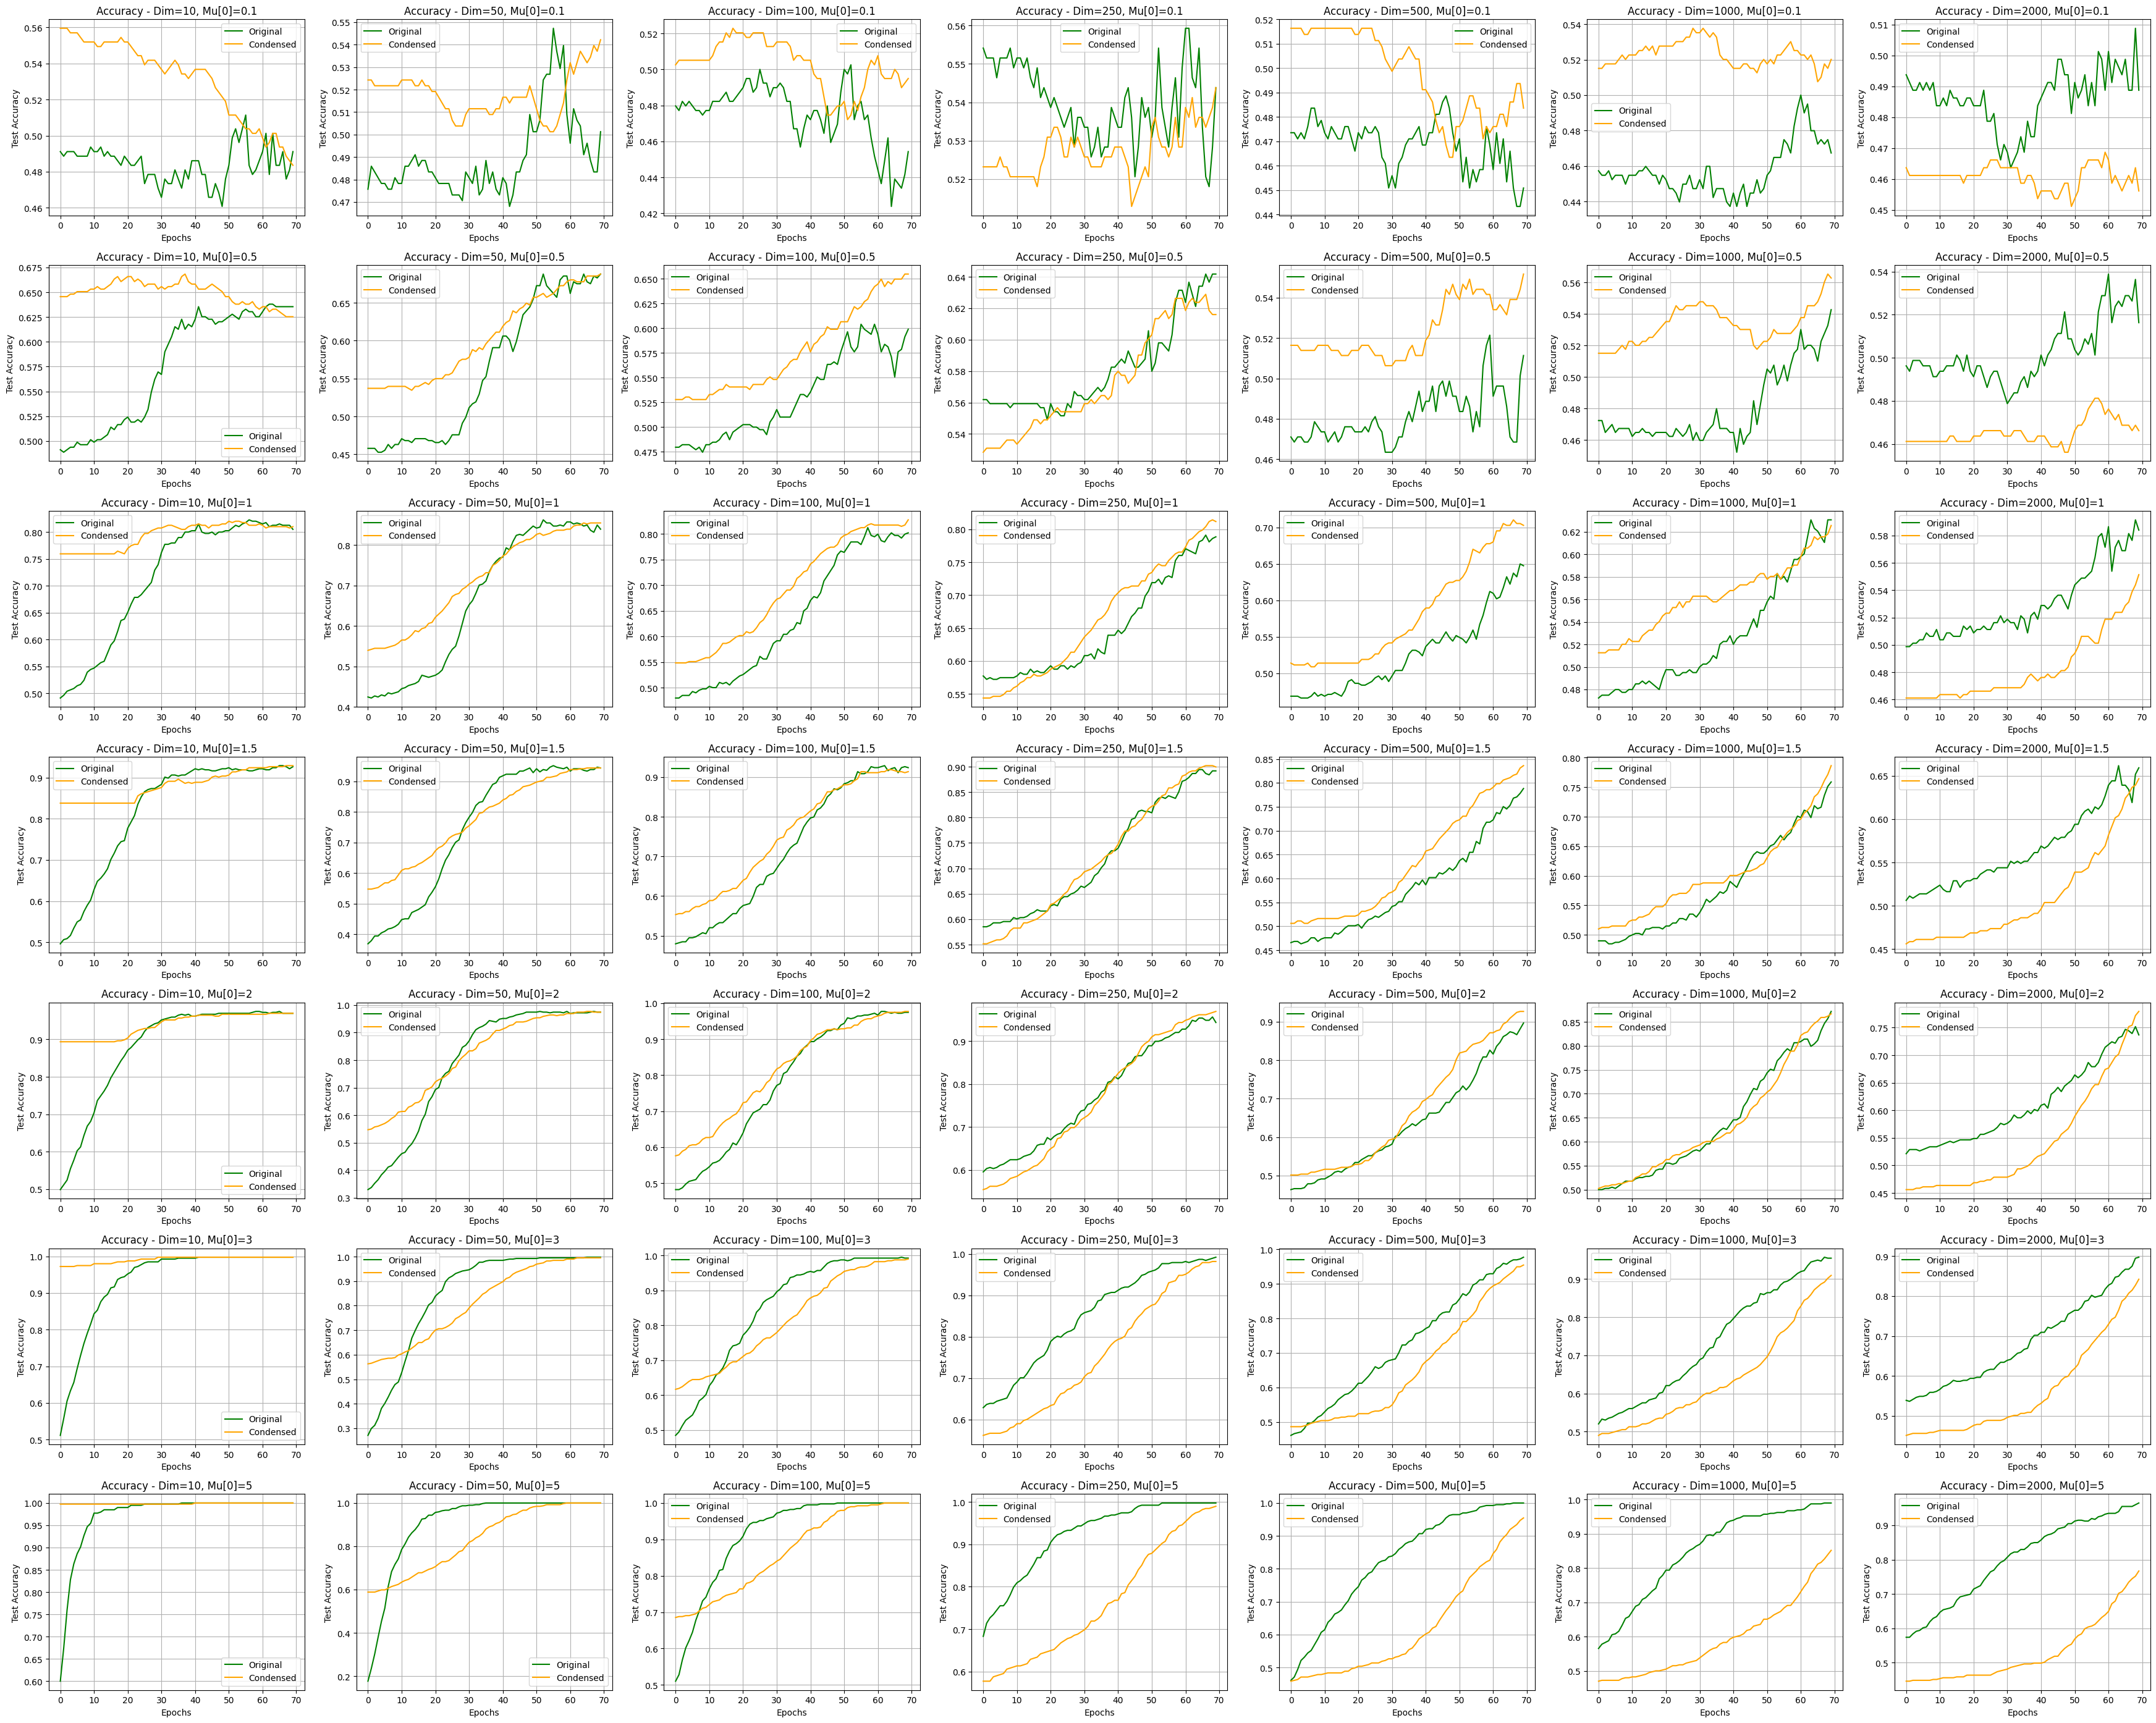

{'original': {(10, 0.1): {'loss': 0.9517916440963745,
   'accuracy': 0.4911392405063291},
  (50, 0.1): {'loss': 0.9783905744552612, 'accuracy': 0.5012787723785166},
  (100, 0.1): {'loss': 0.9424789547920227, 'accuracy': 0.4543147208121827},
  (250, 0.1): {'loss': 0.8891103863716125, 'accuracy': 0.5438144329896907},
  (500, 0.1): {'loss': 0.9415792226791382, 'accuracy': 0.4508816120906801},
  (1000, 0.1): {'loss': 1.0107369422912598, 'accuracy': 0.46733668341708545},
  (2000, 0.1): {'loss': 1.6489877700805664, 'accuracy': 0.48872180451127817},
  (10, 0.5): {'loss': 0.7799468040466309, 'accuracy': 0.6354430379746835},
  (50, 0.5): {'loss': 0.921309769153595, 'accuracy': 0.6879795396419437},
  (100, 0.5): {'loss': 0.8743686676025391, 'accuracy': 0.5989847715736041},
  (250, 0.5): {'loss': 0.8123558759689331, 'accuracy': 0.6417525773195877},
  (500, 0.5): {'loss': 0.8546258211135864, 'accuracy': 0.5113350125944585},
  (1000, 0.5): {'loss': 1.0737249851226807, 'accuracy': 0.542713567839196}

In [ ]:
feature_dims = [10, 50, 100, 250, 500, 1000, 2000]
mu_values = [0.1, 0.5, 1, 1.5, 2, 3, 5]
heatmap_feature_mu(feature_dims, mu_values, config)

🔄 Generating dataset and training SVM on the original dataset (Only once)...
Epoch 10/70 | Loss: 116.4540 | Test Accuracy: 0.5038
Epoch 20/70 | Loss: 41.5906 | Test Accuracy: 0.5642
Epoch 30/70 | Loss: 15.3156 | Test Accuracy: 0.6423
Epoch 40/70 | Loss: 4.8701 | Test Accuracy: 0.6977
Epoch 50/70 | Loss: 1.8552 | Test Accuracy: 0.7809
Epoch 60/70 | Loss: 0.7217 | Test Accuracy: 0.8866
Epoch 70/70 | Loss: 0.3348 | Test Accuracy: 0.9471
🔄 Running experiment for T_out=5, T_in=5...
Epoch 10/70 | Loss: 98.8063 | Test Accuracy: 0.5113
Epoch 20/70 | Loss: 35.8044 | Test Accuracy: 0.5516
Epoch 30/70 | Loss: 13.1773 | Test Accuracy: 0.6045
Epoch 40/70 | Loss: 5.0684 | Test Accuracy: 0.7204
Epoch 50/70 | Loss: 2.1778 | Test Accuracy: 0.8589
Epoch 60/70 | Loss: 1.1325 | Test Accuracy: 0.9295
Epoch 70/70 | Loss: 0.7571 | Test Accuracy: 0.9622
✅ Done: T_out=5, T_in=5 -> Loss(Cond): 0.7571, Acc(Cond): 0.9622
🔄 Running experiment for T_out=5, T_in=10...
Epoch 10/70 | Loss: 98.8746 | Test Accuracy: 0.4

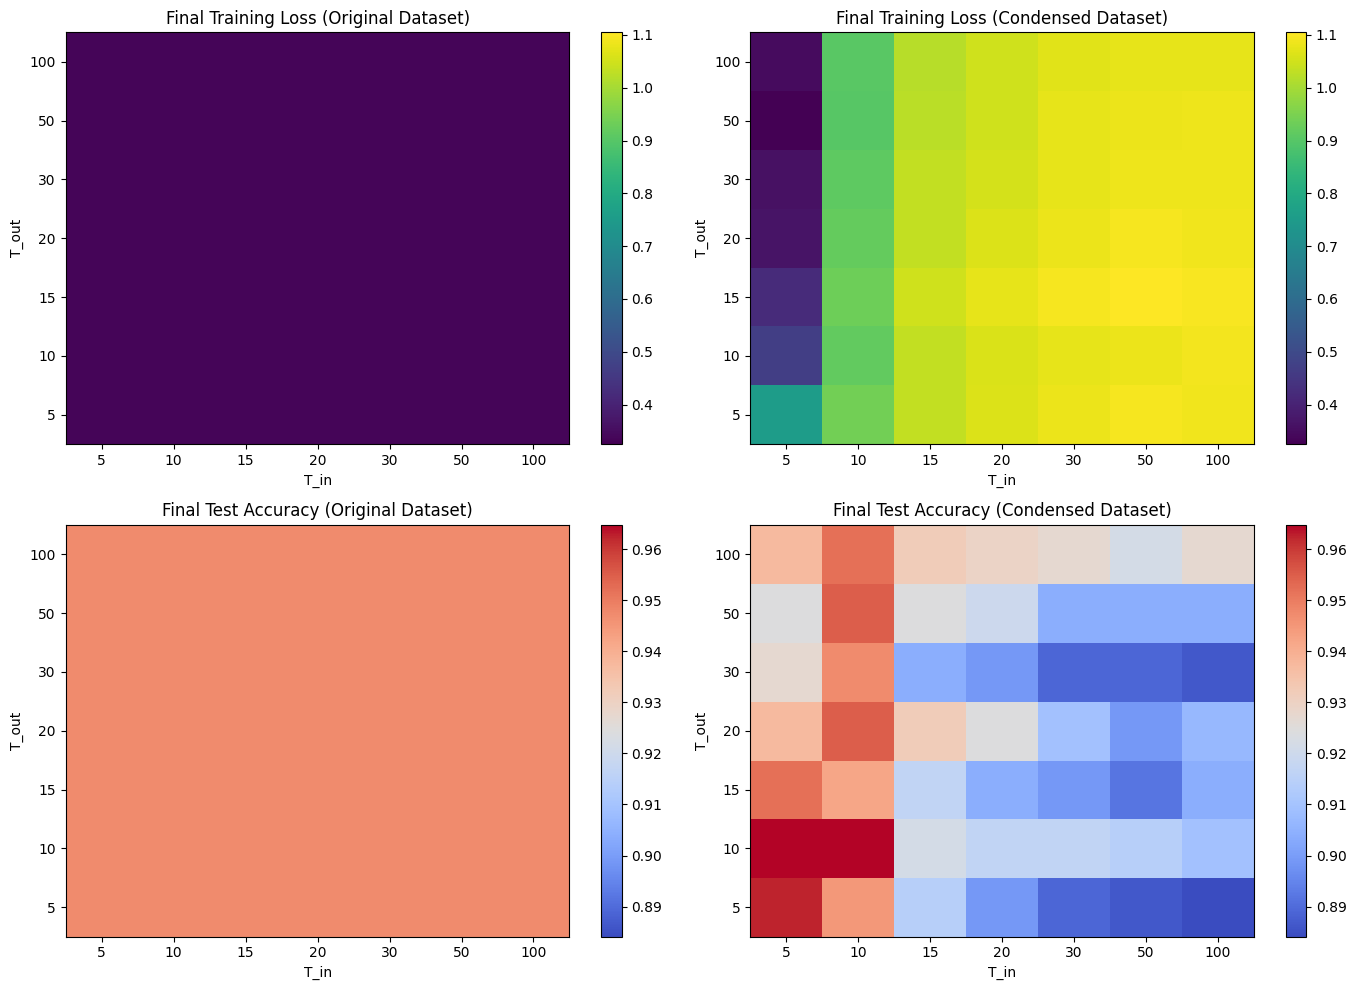

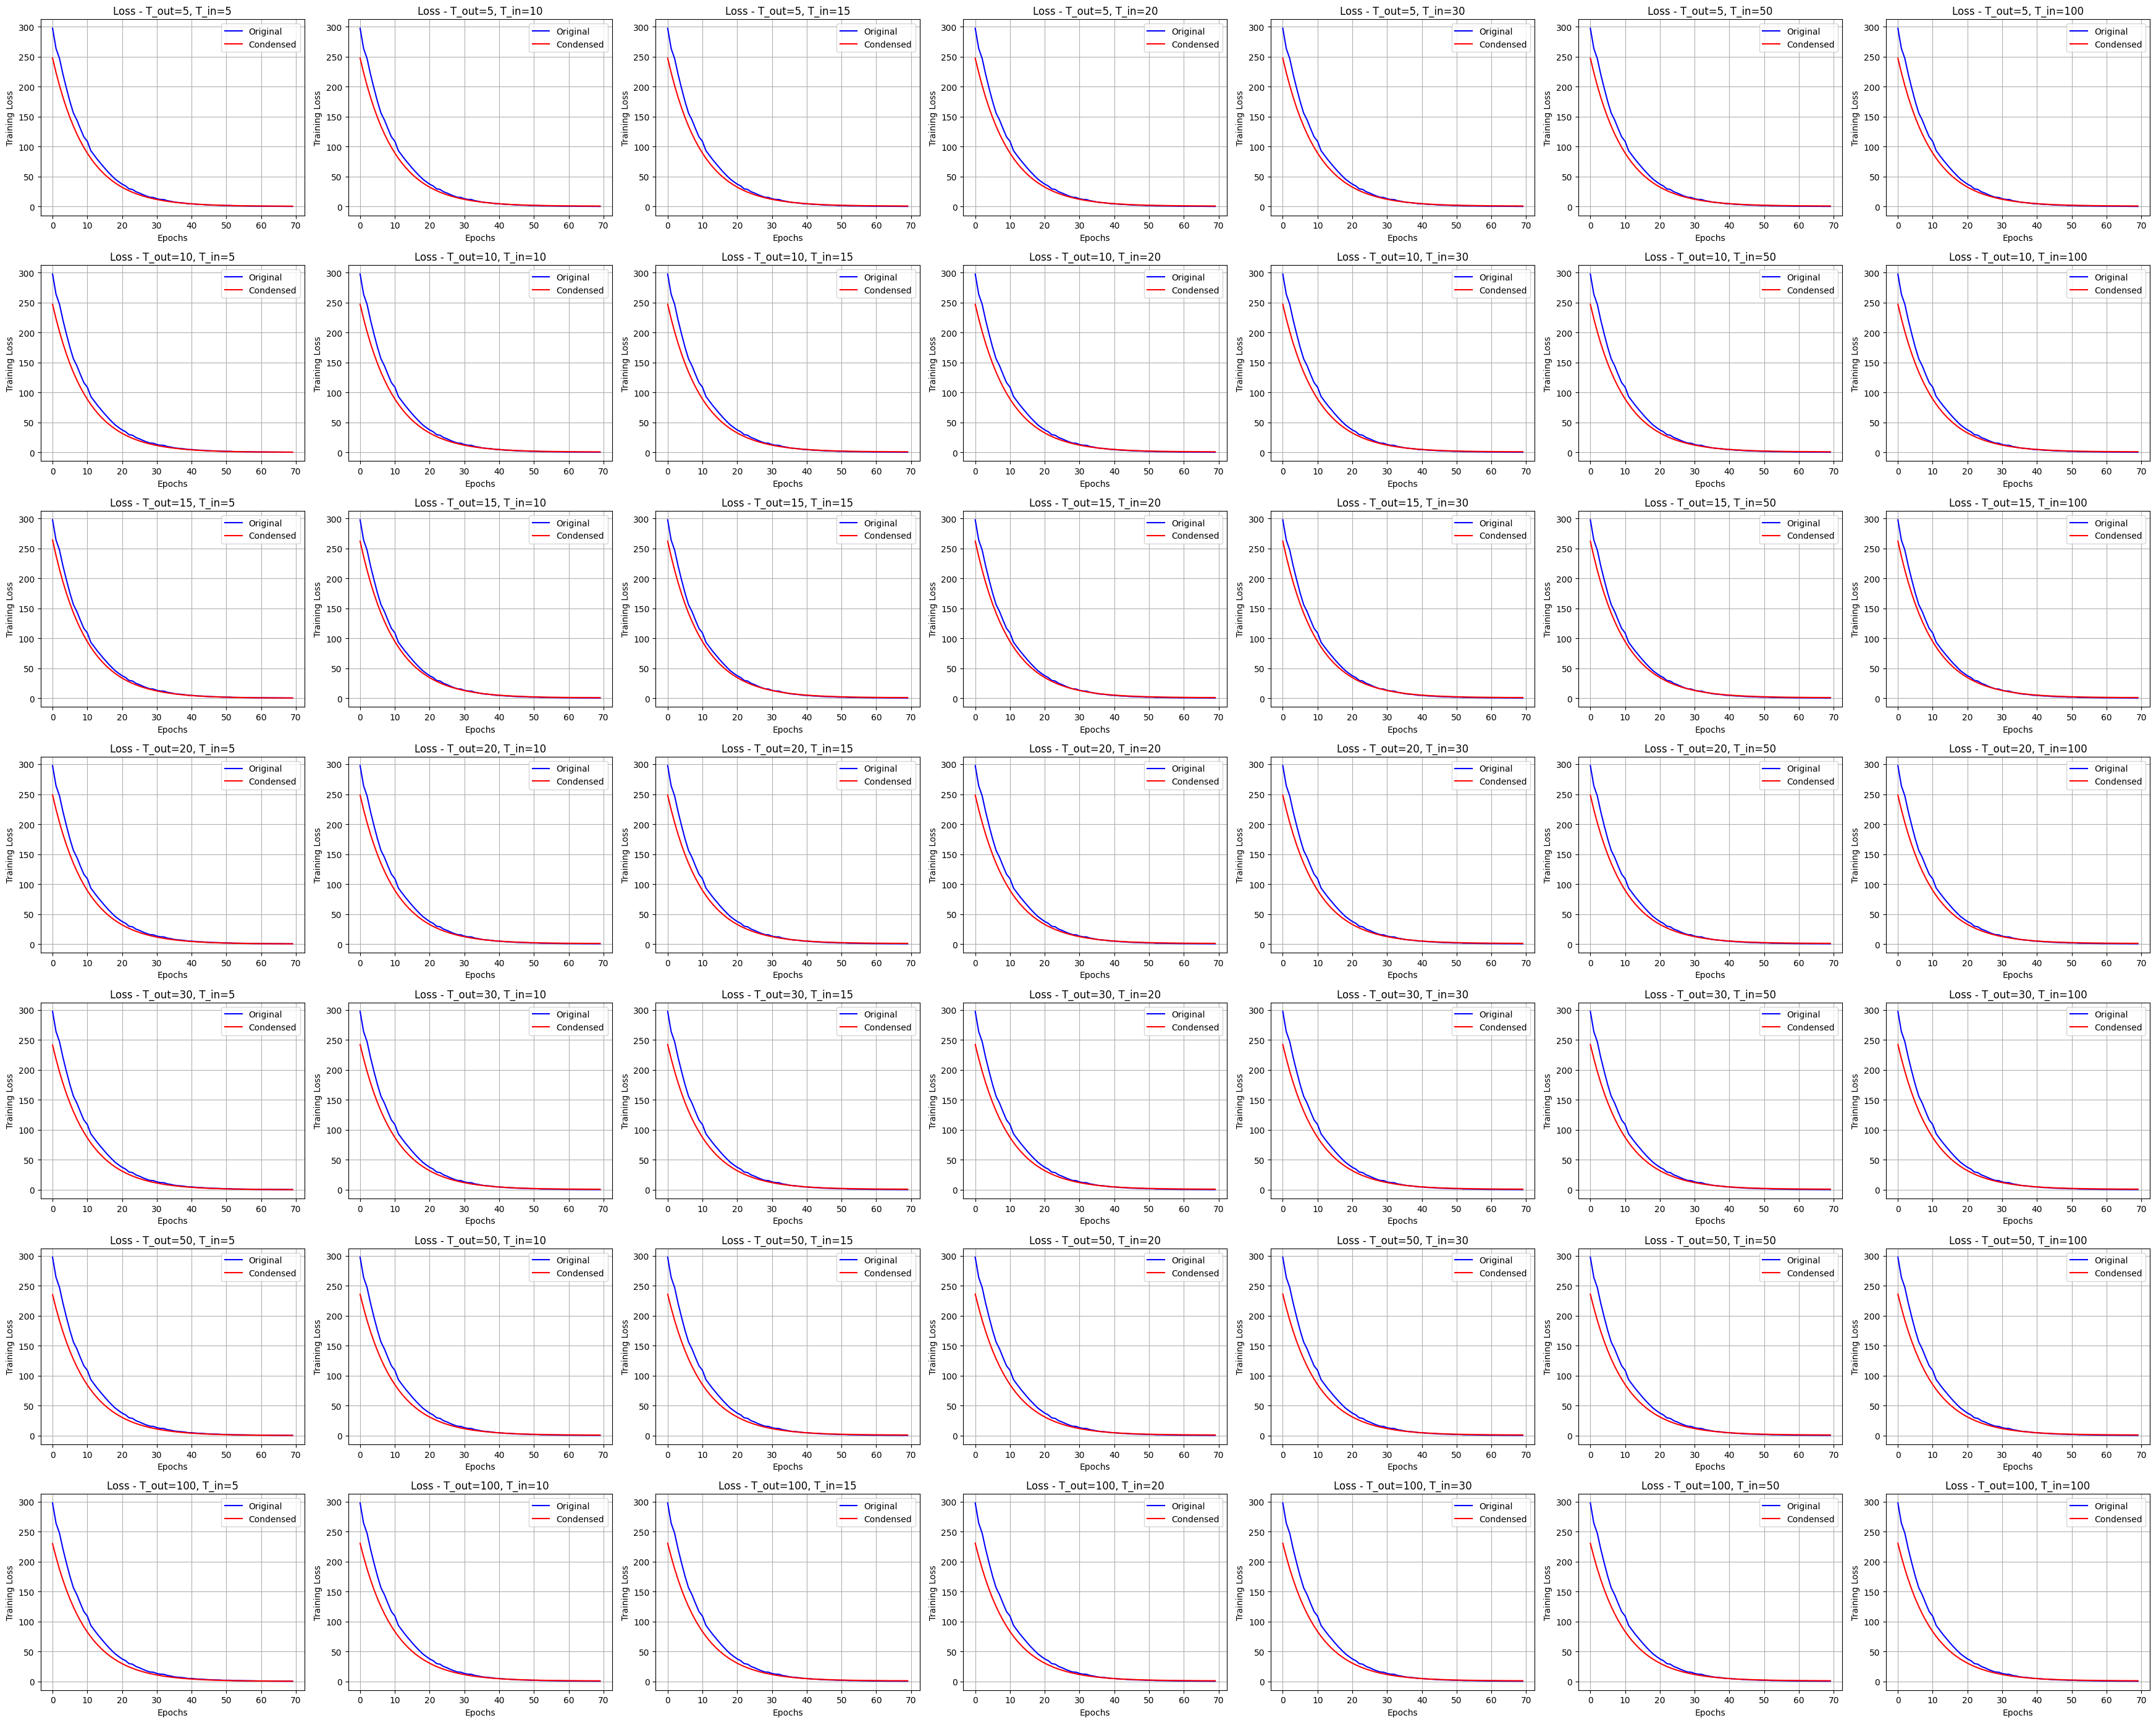

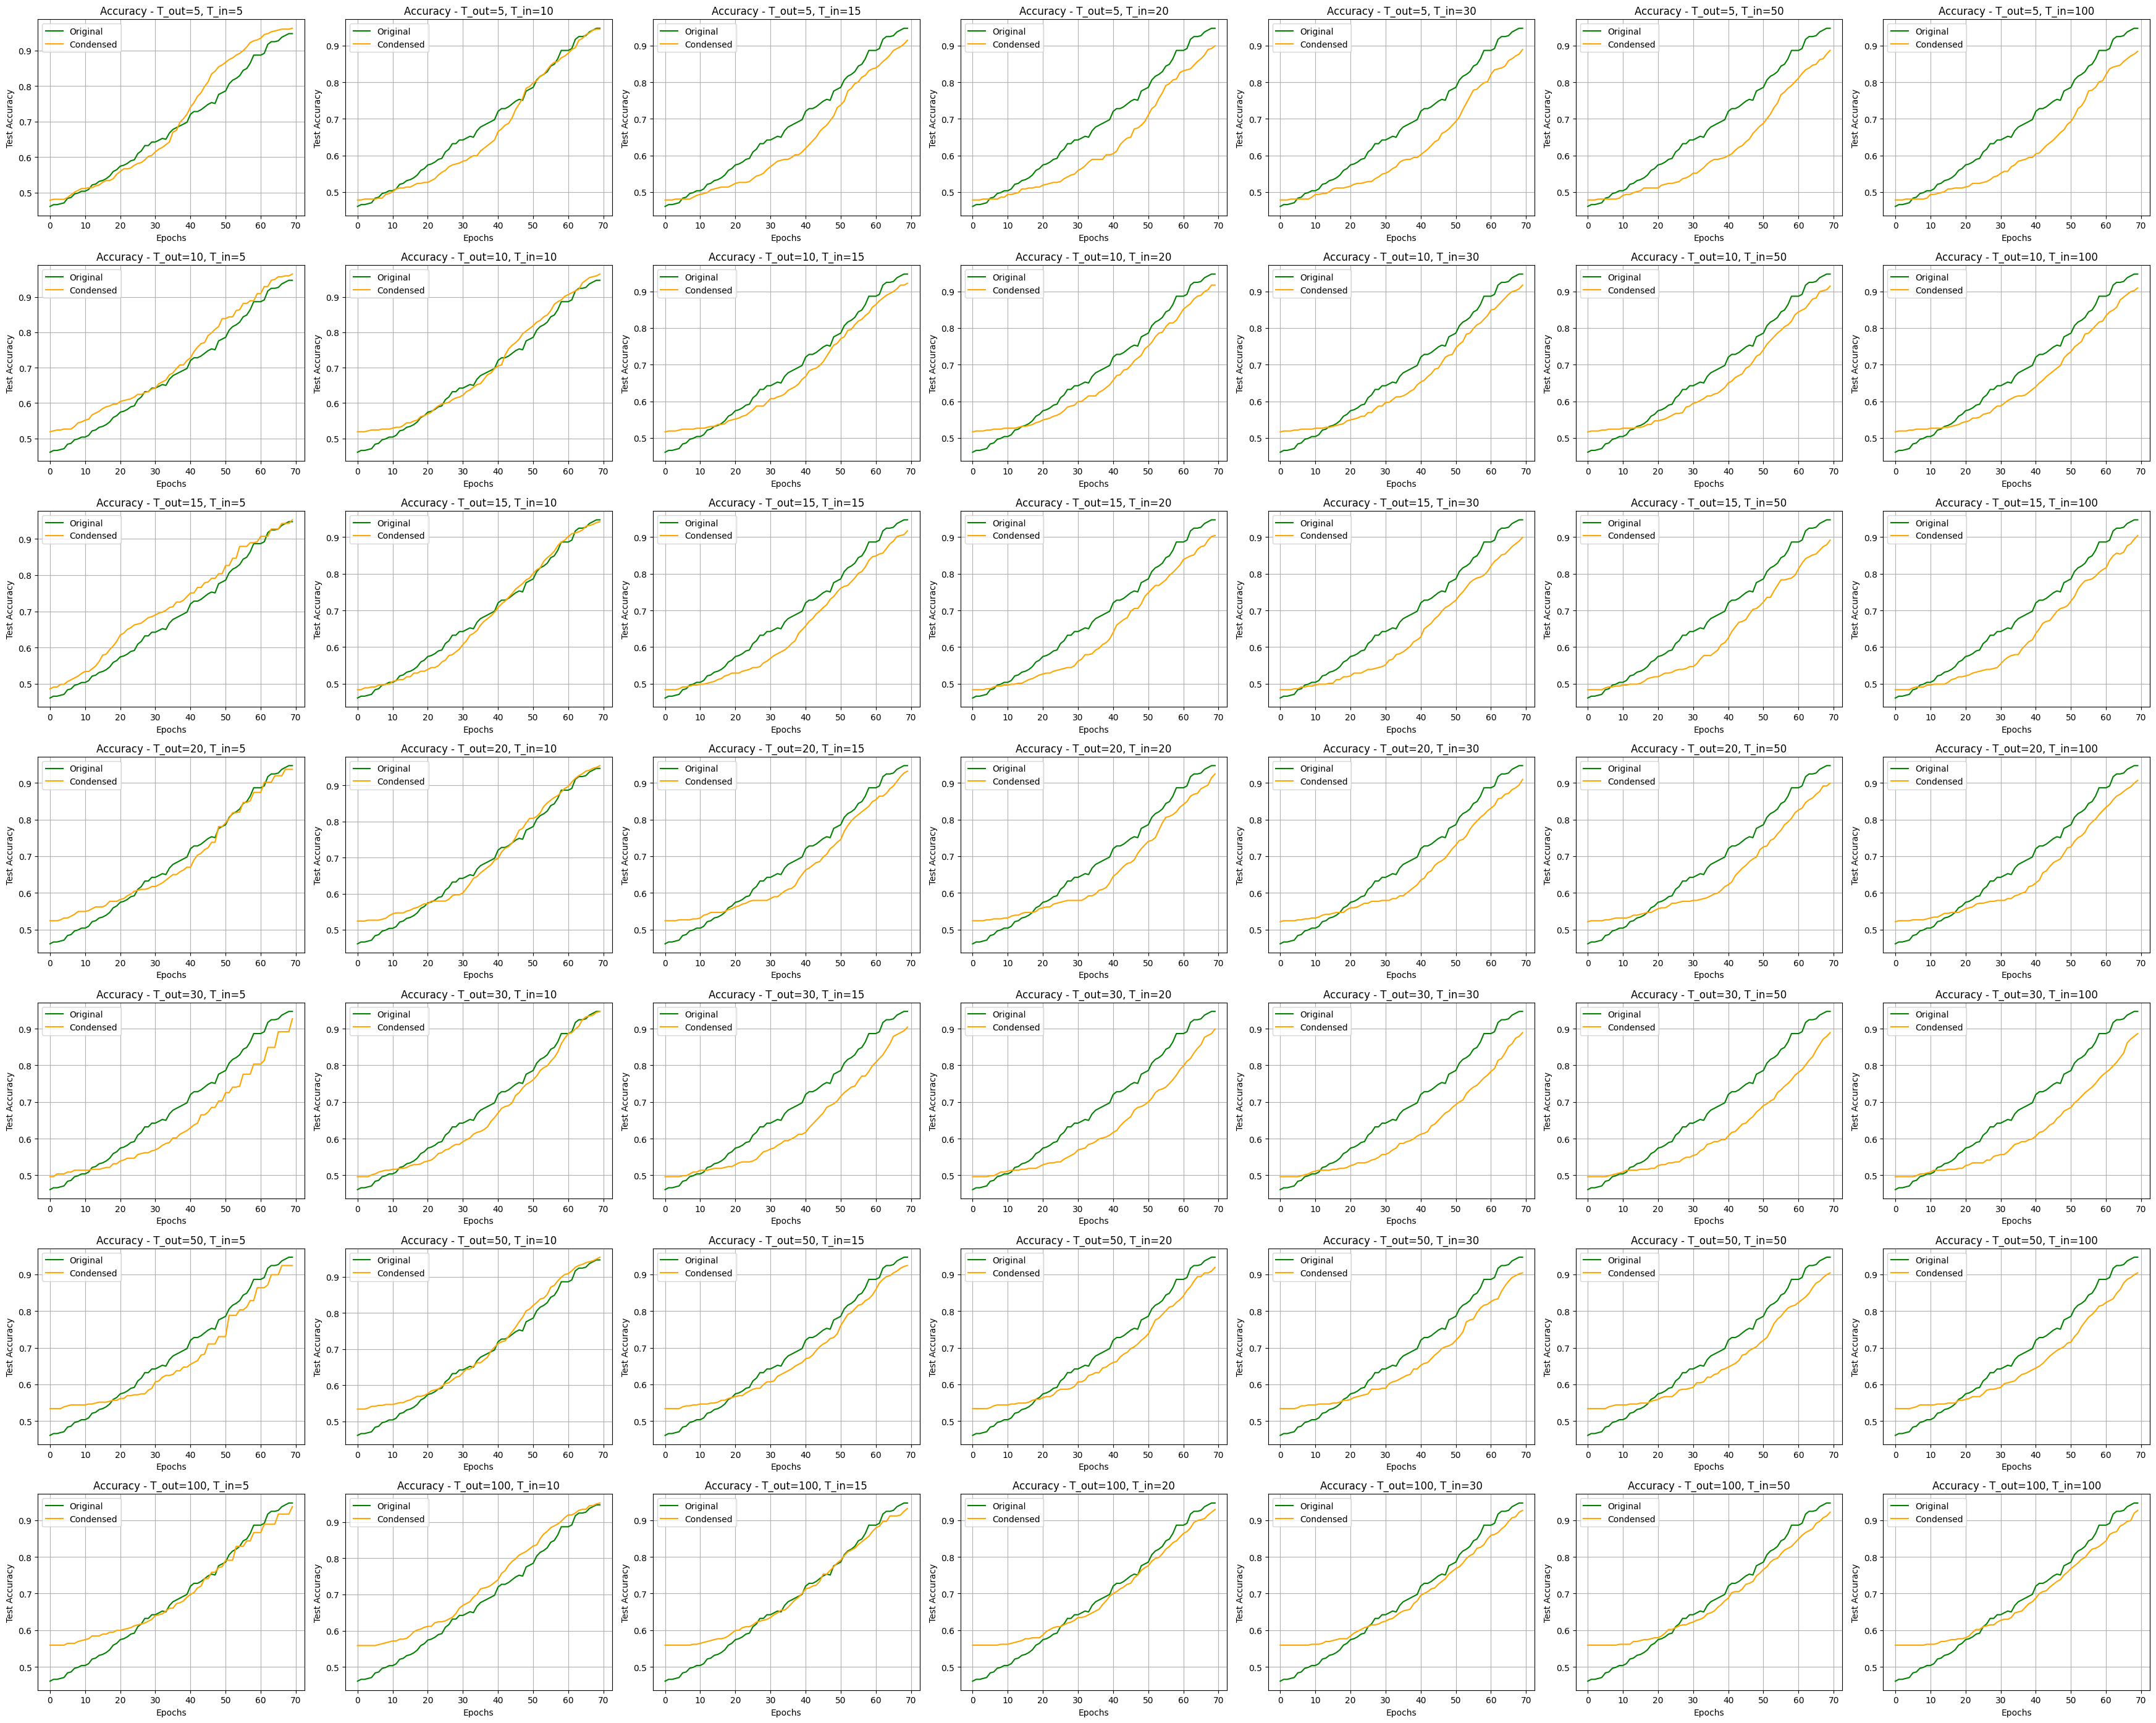

{'original': {},
 'condensed': {(5, 5): {'loss': 0.7571430802345276,
   'accuracy': 0.9622166246851386},
  (5, 10): {'loss': 0.9395948648452759, 'accuracy': 0.9445843828715366},
  (5, 15): {'loss': 1.0330305099487305, 'accuracy': 0.9143576826196473},
  (5, 20): {'loss': 1.0650969743728638, 'accuracy': 0.8992443324937027},
  (5, 30): {'loss': 1.0826942920684814, 'accuracy': 0.889168765743073},
  (5, 50): {'loss': 1.0932071208953857, 'accuracy': 0.8866498740554156},
  (5, 100): {'loss': 1.0886468887329102, 'accuracy': 0.8841309823677582},
  (10, 5): {'loss': 0.46974989771842957, 'accuracy': 0.964735516372796},
  (10, 10): {'loss': 0.9181658029556274, 'accuracy': 0.964735516372796},
  (10, 15): {'loss': 1.032287836074829, 'accuracy': 0.9219143576826196},
  (10, 20): {'loss': 1.0608417987823486, 'accuracy': 0.9168765743073047},
  (10, 30): {'loss': 1.0752272605895996, 'accuracy': 0.9168765743073047},
  (10, 50): {'loss': 1.083512544631958, 'accuracy': 0.9143576826196473},
  (10, 100): {'lo

In [ ]:
Tin_values = [5, 10, 15 ,20, 30, 50, 100]
Tout_values = [5, 10, 15 ,20, 30, 50, 100]
heatmap_Tin_Tout(Tin_values, Tout_values, config)

🔄 Running experiment for n_samples=100, pos_ratio=0.05...
Epoch 10/70 | Loss: 95.9760 | Test Accuracy: 0.5238
Epoch 20/70 | Loss: 33.9322 | Test Accuracy: 0.5238
Epoch 30/70 | Loss: 12.0012 | Test Accuracy: 0.5238
Epoch 40/70 | Loss: 4.2672 | Test Accuracy: 0.5238
Epoch 50/70 | Loss: 1.5515 | Test Accuracy: 0.5238
Epoch 60/70 | Loss: 0.5758 | Test Accuracy: 0.5714
Epoch 70/70 | Loss: 0.2304 | Test Accuracy: 0.6667
Epoch 10/70 | Loss: 104.3933 | Test Accuracy: 0.5238
Epoch 20/70 | Loss: 38.0532 | Test Accuracy: 0.5238
Epoch 30/70 | Loss: 14.2704 | Test Accuracy: 0.5238
Epoch 40/70 | Loss: 5.7558 | Test Accuracy: 0.5238
Epoch 50/70 | Loss: 2.7018 | Test Accuracy: 0.5238
Epoch 60/70 | Loss: 1.6039 | Test Accuracy: 0.5238
Epoch 70/70 | Loss: 1.2108 | Test Accuracy: 0.5238
✅ Done: n_samples=100, pos_ratio=0.05 -> Loss(Orig): 0.2304, Acc(Orig): 0.6667, Loss(Cond): 1.2108, Acc(Cond): 0.5238
🔄 Running experiment for n_samples=200, pos_ratio=0.05...
Epoch 10/70 | Loss: 101.2549 | Test Accuracy:

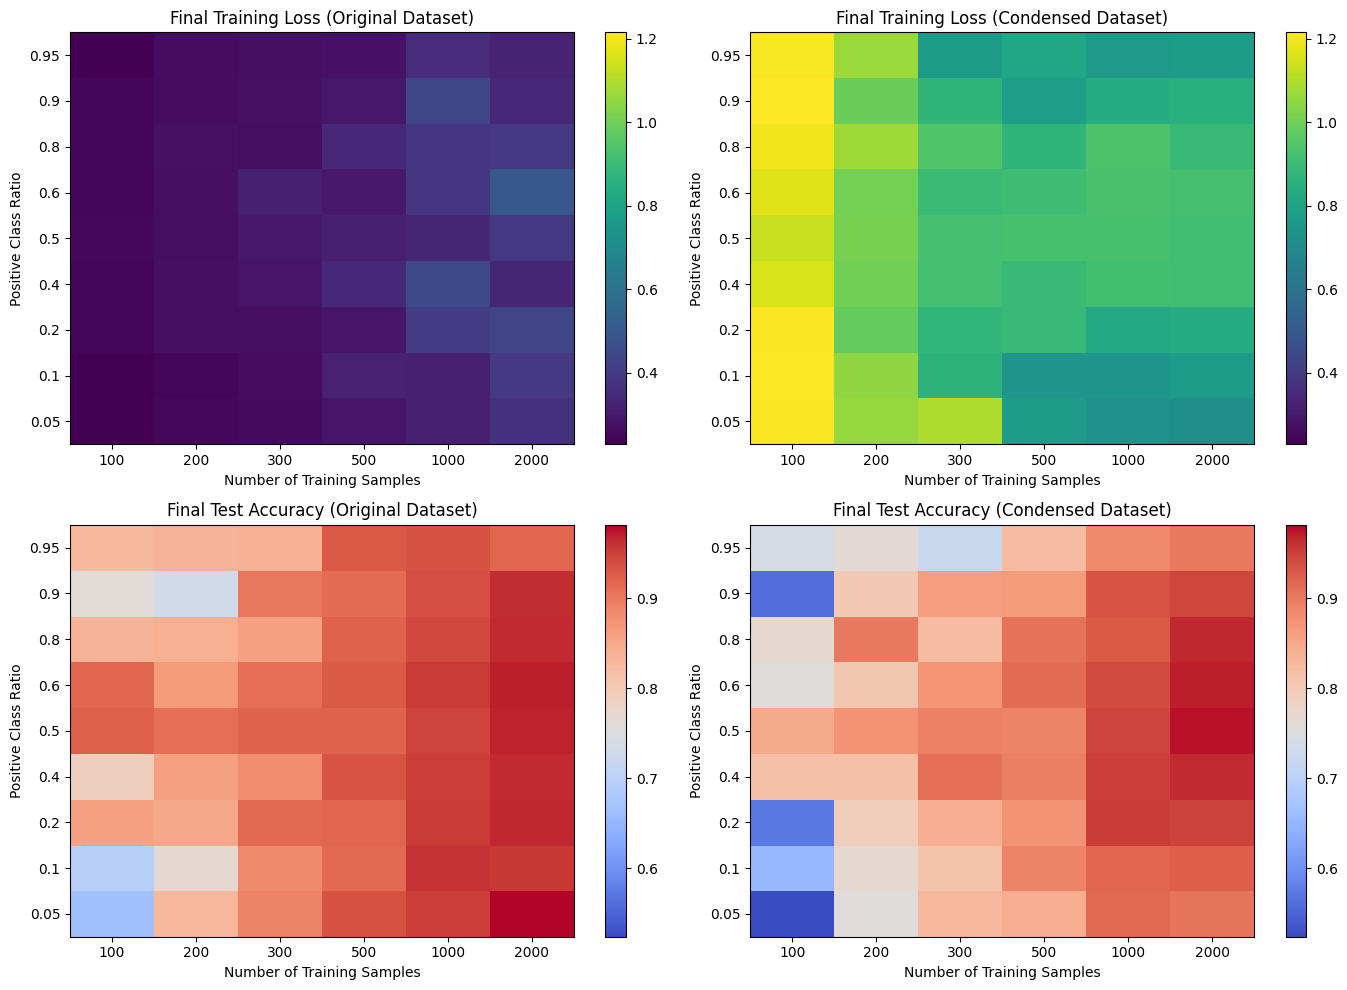

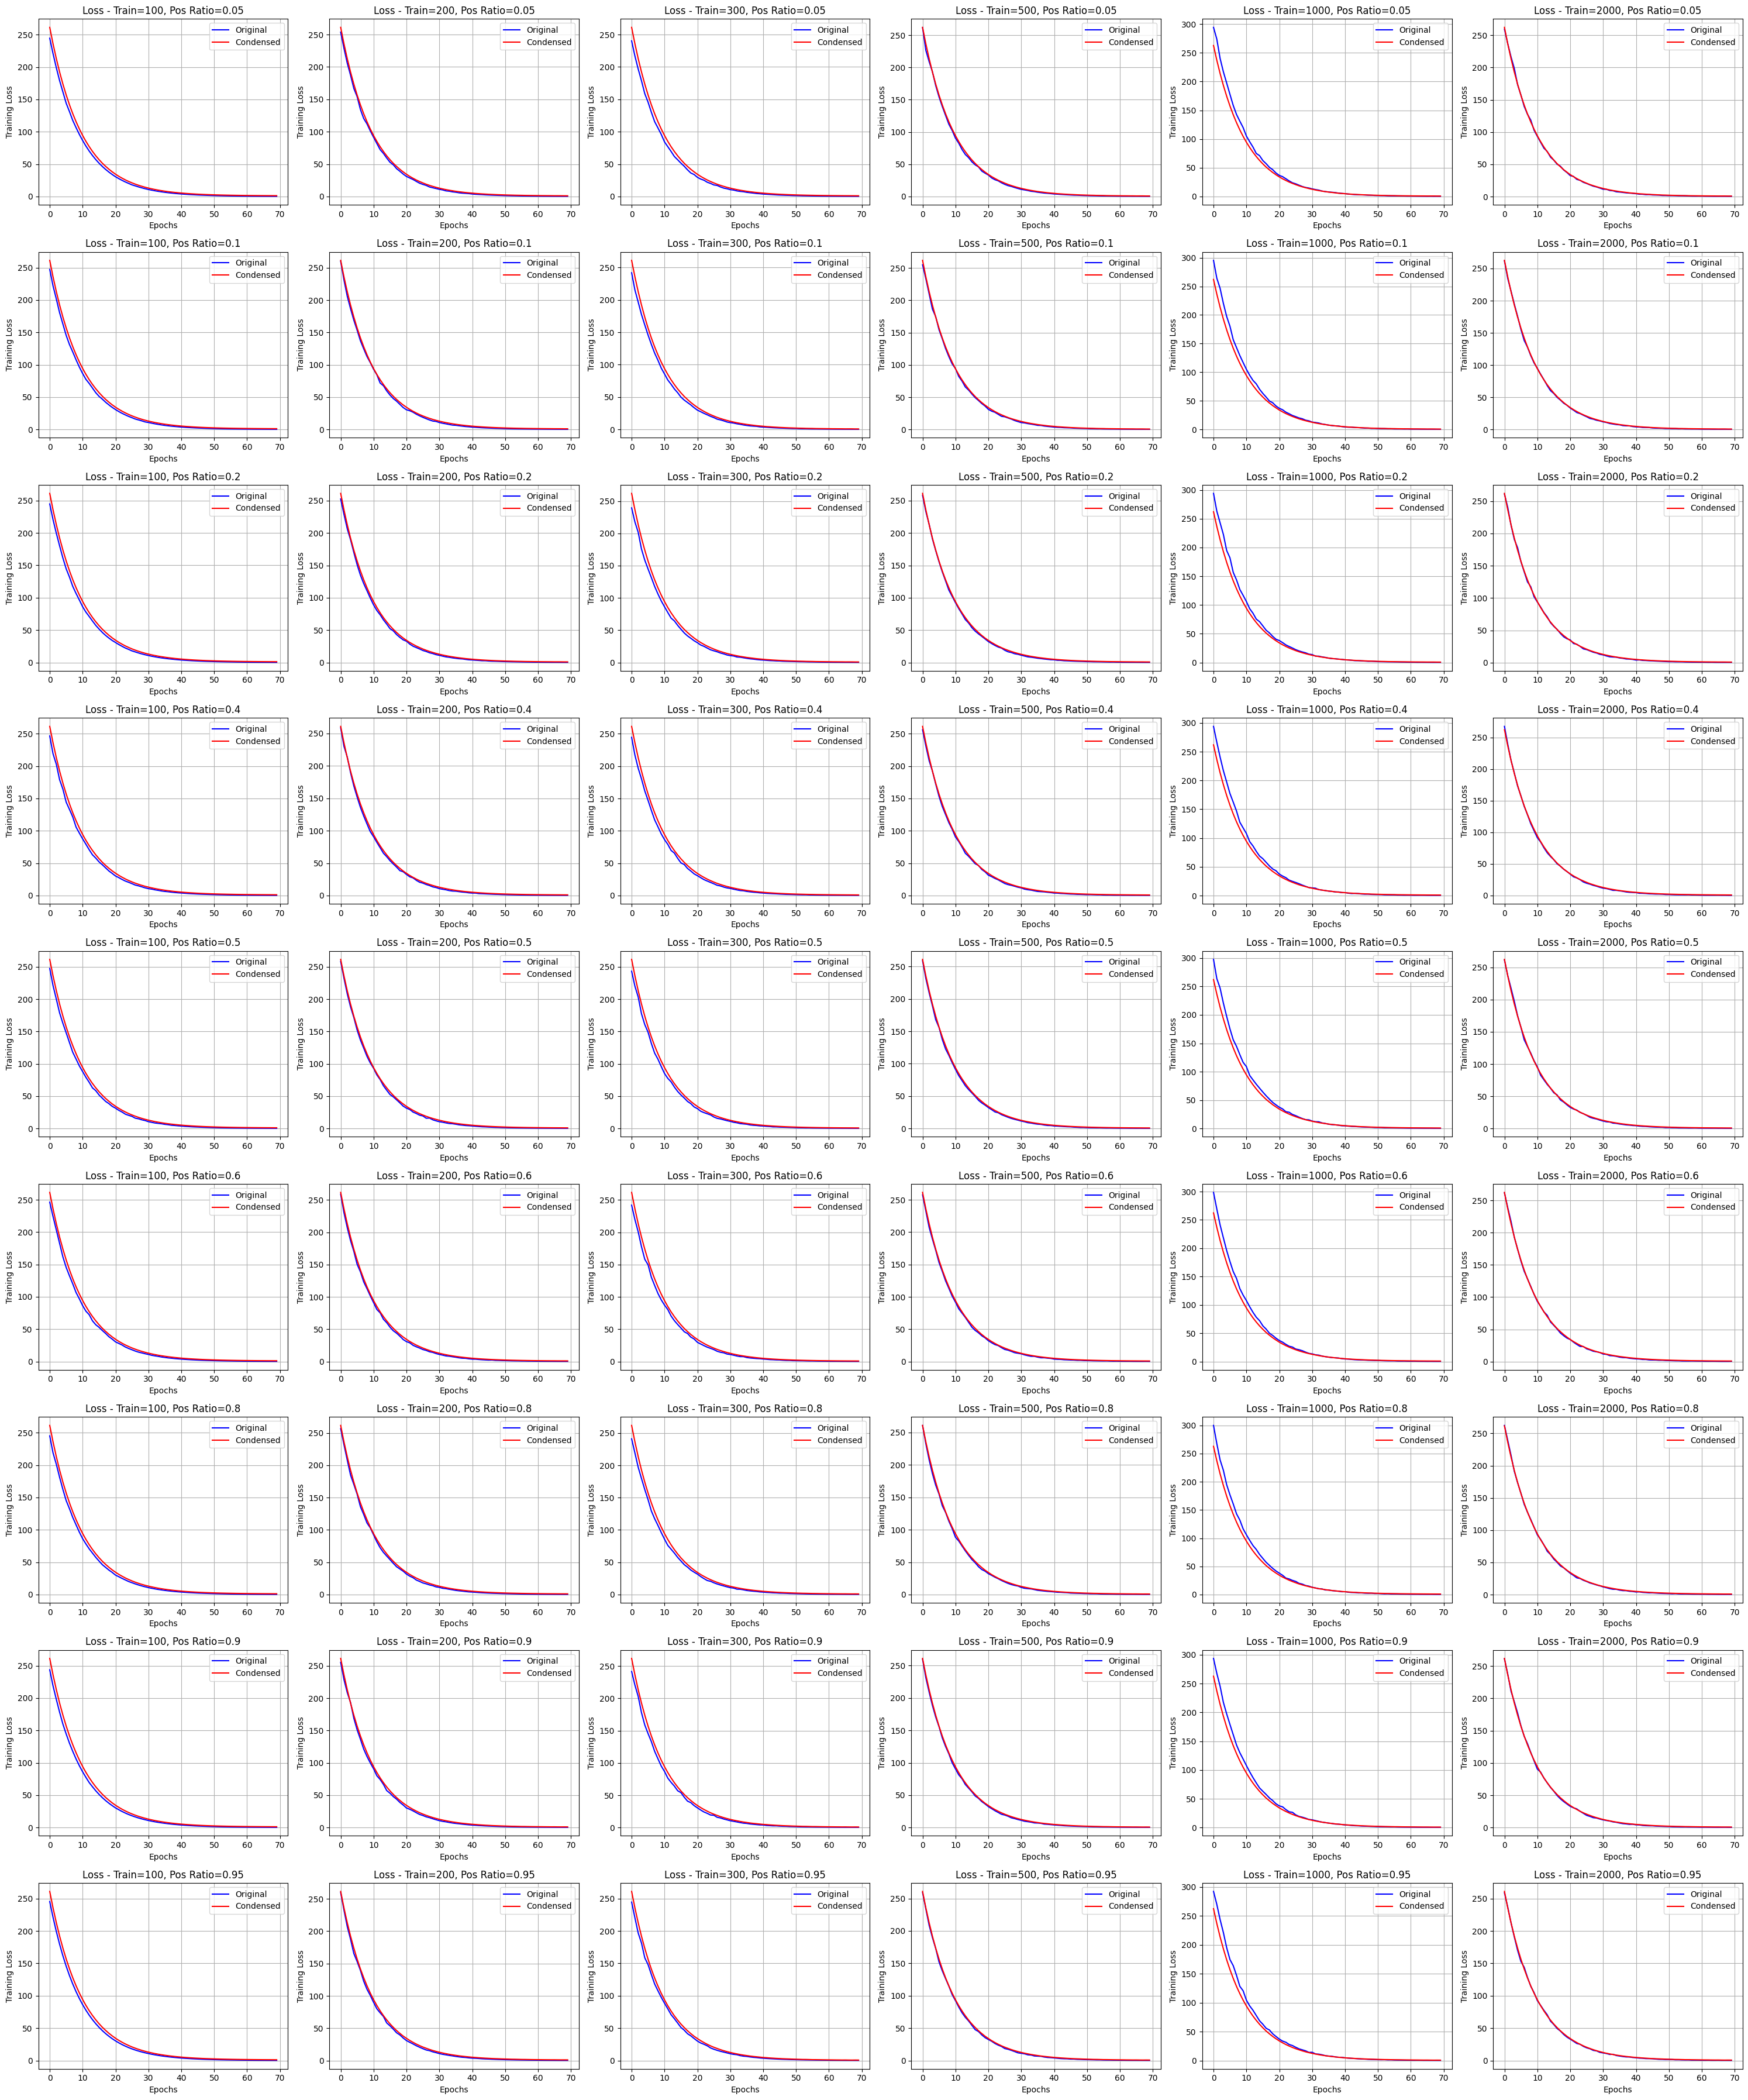

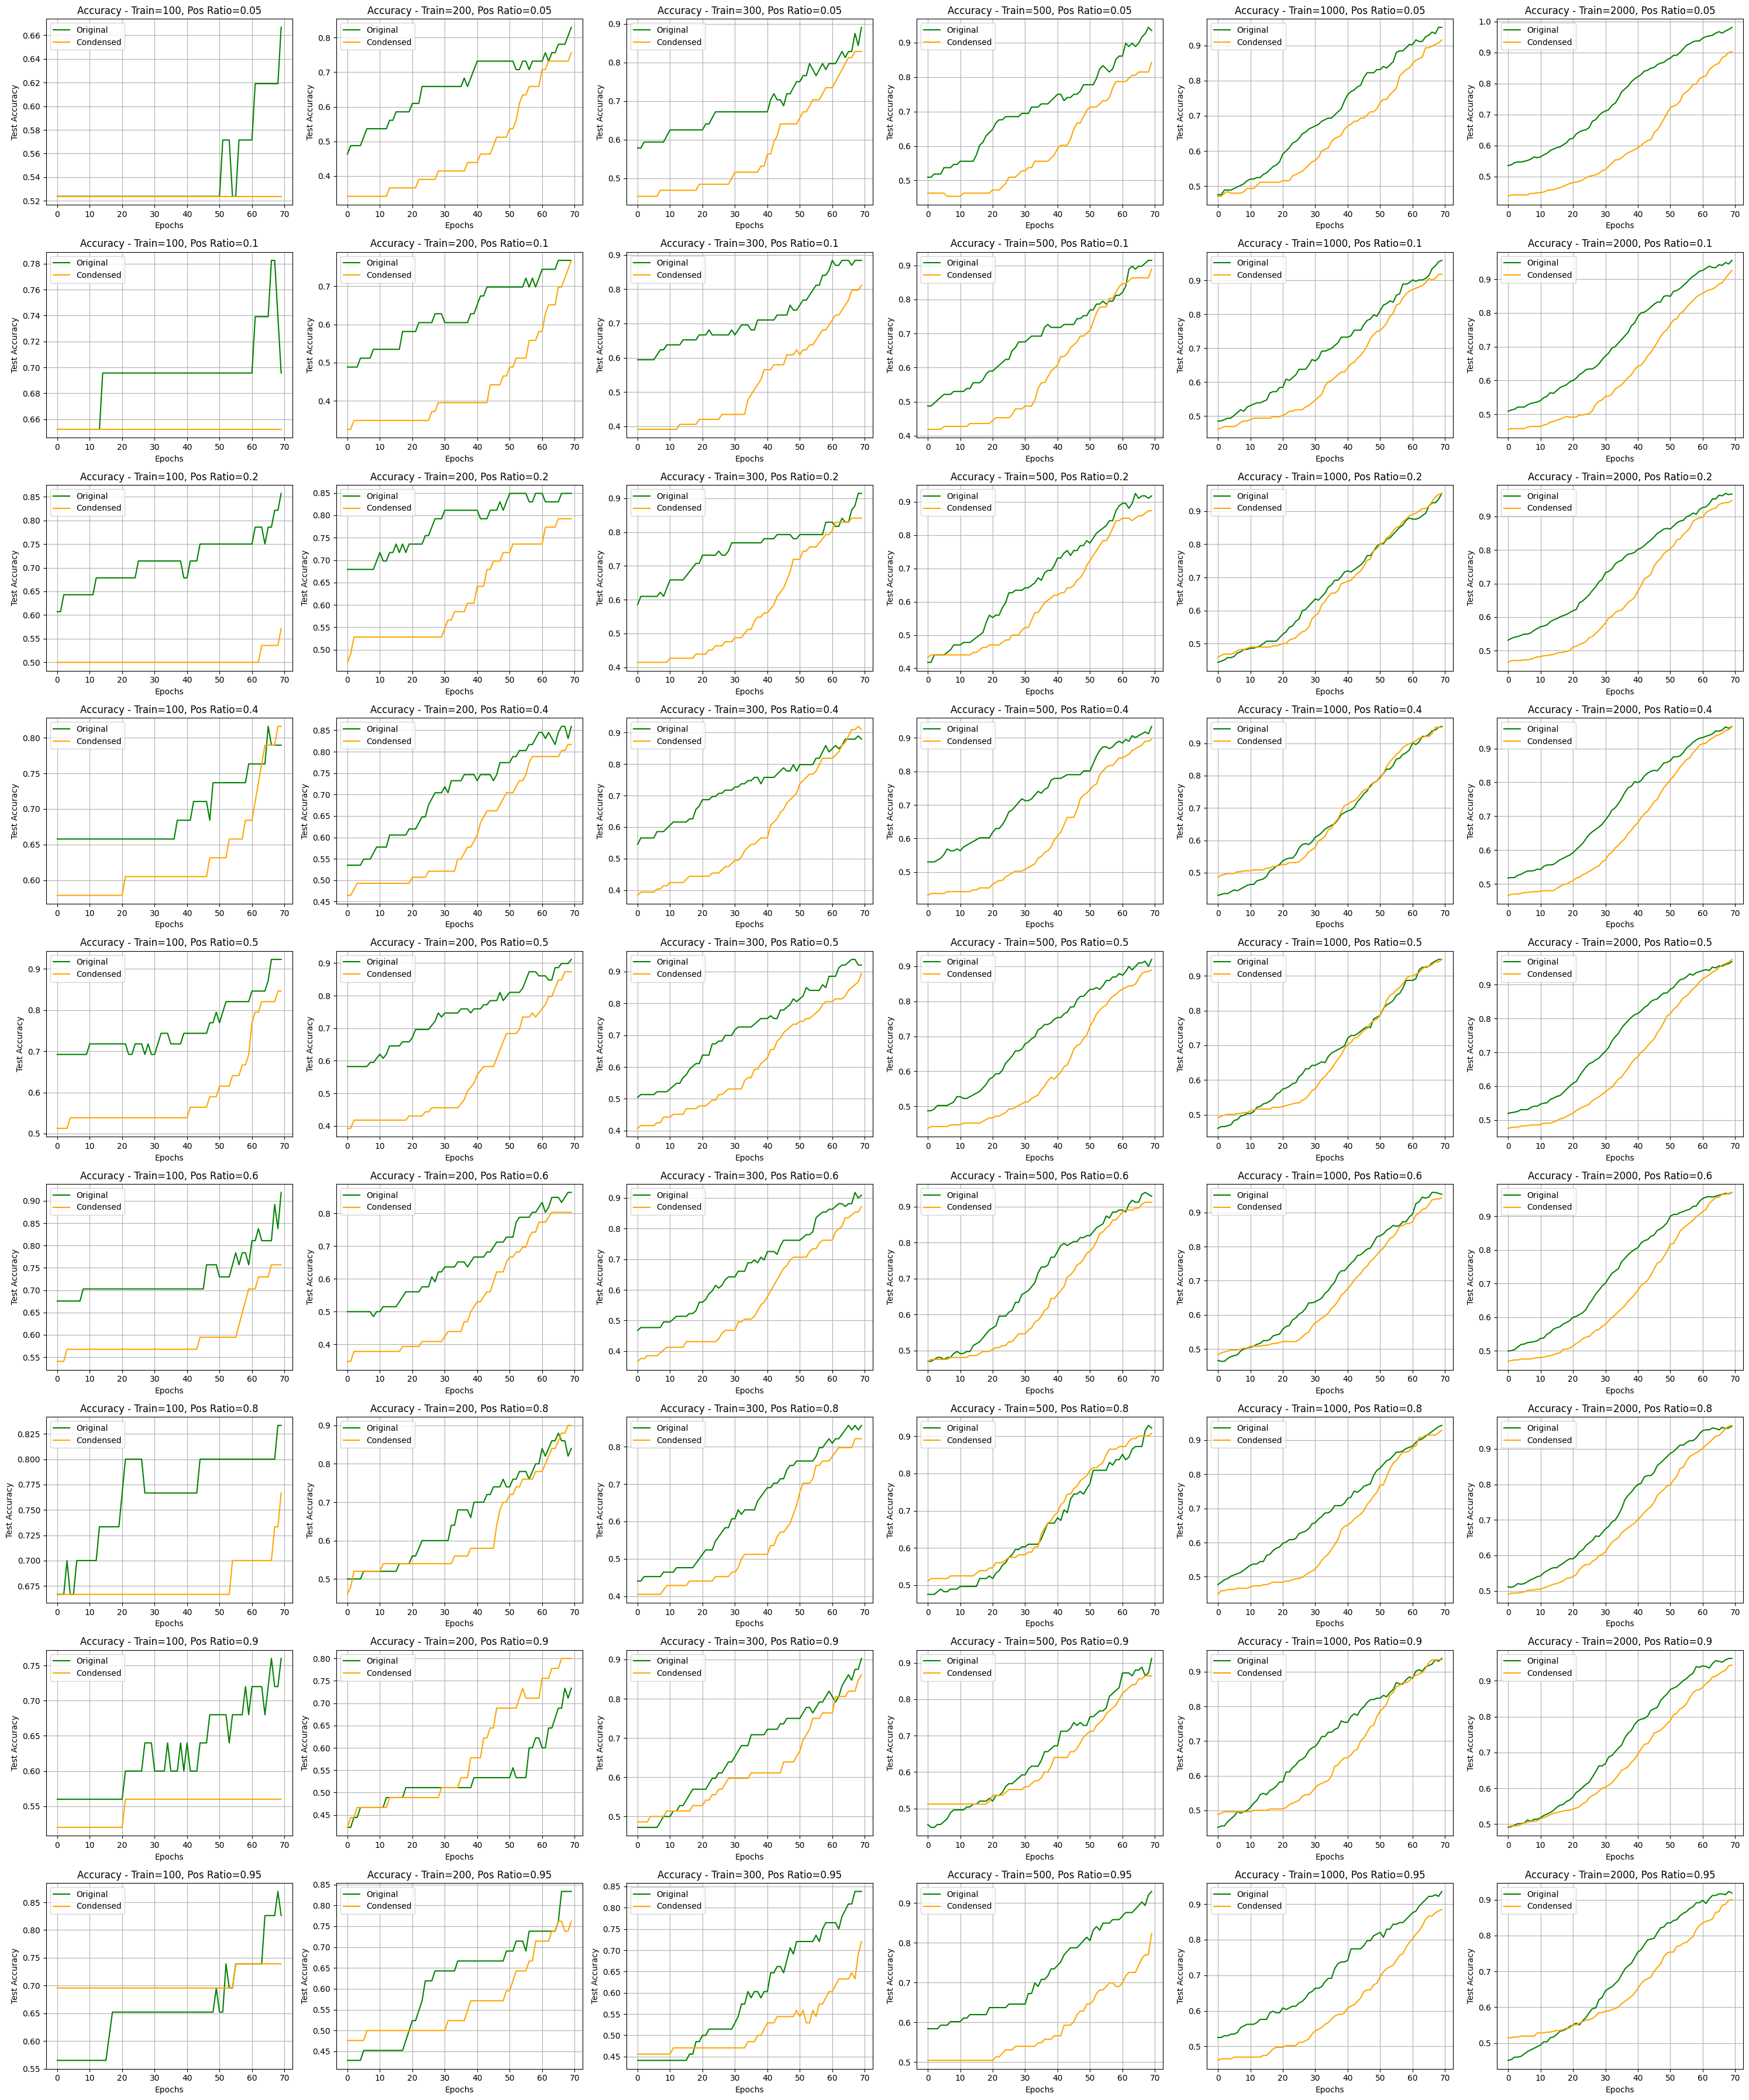

In [ ]:
n_samples_list = [100, 200, 300, 500, 1000, 2000]
pos_ratio_list = [0.05, 0.1, 0.2, 0.4, 0.5, 0.6, 0.8, 0.9, 0.95]

results_samples_posratio = heatmap_samples_posratio(n_samples_list, pos_ratio_list, config)